# Предсказание вида (аспекта) сербских глаголов
## _На материалах UD_Serbian-SET_

Основная идея: в _UD_Serbian-SET_ не размечен глагольный вид, но существующих данных и инструментов достаточно, чтобы можно было разметить небольшое количество данных и обучить модель высокоточно предсказывать (почти) всю генеральную совокупность.

### Импорты, настройки, глобальные переменные

In [1]:
import pandas as pd
import csv
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import FeatureImportances

import numpy as np
from gensim.models import Word2Vec

import torch
from itertools import product
from tqdm import tqdm
import re

from sklearn.model_selection import train_test_split
import numpy as np

import datetime
from nltk import word_tokenize

In [2]:
class Log:

    cols = ["experiment_name", "experiment_group", "model_name", "PCA", "F1_cv", "F1_holdout", "F1_unkn"]

    def __init__(self, fname: Path, sep: str):

        self.fname = fname
        self.sep = sep

        if not self.fname.exists():
            with open(fname, "w", encoding="utf-8") as file:
                file.write(self.sep.join(self.cols) + "\n")

    def write(self, vals):
        with open(self.fname, "a+", encoding="utf-8") as file:
            file.write(self.sep.join(vals) + "\n")

In [3]:
PAD_TOK = "[PAD]"
RANDOM_STATE = 42

DATADIR = Path.cwd() / "data"
DATAPATH = DATADIR / "datasetForAnalysis.csv"

LOGNAME_TMPL = datetime.datetime.now().strftime("%I-%M%p on %B %d %Y.csv")
SEP = "\t"

%matplotlib inline
SNS_COLOR = "coolwarm"

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings("ignore")

In [4]:
LOG = Log(DATADIR / LOGNAME_TMPL, SEP)

### Вспомогательные функции

In [5]:
def plot_corr(X: pd.DataFrame, trh=0.33):

    X_cpy = X.copy(deep=True)

    label_encoder = LabelEncoder()
    for column in X_cpy.columns:
        X_cpy[column] = label_encoder.fit_transform(X_cpy[column])

    corr= X_cpy.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(
        corr,
        mask=np.abs(corr) < trh,
        annot=True,
        fmt=".2f",
        cmap=SNS_COLOR,
        vmin=-1,
        vmax=1
    )
    plt.title("Correlation Matrix")
    plt.show()

In [6]:
def plot_freqs(df, col, hue=None, n=20):

    if hue:
        counts = df.groupby([col, hue]).size().reset_index(name="count")
    else:
        counts = df[col].value_counts().reset_index()

    top_n = df[col].value_counts().iloc[:n].index
    counts = counts[counts[col].isin(top_n)]

    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=counts,
        x=col,
        y="count",
        palette=SNS_COLOR,
        hue=hue,
    )
    plt.xticks(rotation=30)
    plt.title(f"{col.capitalize()} Counts")
    plt.tight_layout()
    plt.show()

In [7]:
def plot_metrics(df, m, min_=0.1):
    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=df,
        x="experiment_name",
        y=m,
        hue="model_name",
        palette=SNS_COLOR,
        errorbar=None,
    )
    plt.xlabel("Experiment")
    plt.ylabel(f"{m} Score")
    plt.ylim(min_, 1.0)
    plt.tick_params(axis="x", rotation=30)

    plt.show()

In [8]:
def one_hot_encode(X_train:pd.DataFrame, *X_tests: list[pd.DataFrame]):

    X_train_cpy = X_train.copy(deep=True)

    X_tests_cpy = [
        X_test.copy(deep=True)
        for X_test
        in X_tests
    ]

    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    pandas_columns = X_train_cpy.columns

    X_train_cpy = pd.DataFrame(encoder.fit_transform(X_train_cpy))
    X_tests_cpy = [
        pd.DataFrame(encoder.transform(X_test_cpy))
        for X_test_cpy
        in X_tests_cpy
    ]

    new_columns = encoder.get_feature_names_out(pandas_columns)
    new_columns = [re.sub(r"\[|\]", "_", col) for col in new_columns]

    X_train_cpy.columns = new_columns
    for X_test_cpy in X_tests_cpy:
        X_test_cpy.columns = new_columns

    return X_train_cpy, *X_tests_cpy

In [9]:
def pca_shrink(n, X_train:pd.DataFrame, *X_tests: list[pd.DataFrame]):

    X_train_cpy = X_train.copy(deep=True)

    X_tests_cpy = [
        X_test.copy(deep=True)
        for X_test
        in X_tests
    ]

    encoder = PCA(n_components=n)

    X_train_cpy = pd.DataFrame(encoder.fit_transform(X_train_cpy))
    X_tests_cpy = [
        pd.DataFrame(encoder.transform(X_test_cpy))
        for X_test_cpy
        in X_tests_cpy
    ]

    return X_train_cpy, *X_tests_cpy

In [10]:
def onehot_and_pca(n, X_train:pd.DataFrame, *X_tests: list[pd.DataFrame]):
    X_train_onehot, *X_tests_onehot = one_hot_encode(X_train, *X_tests)
    return pca_shrink(n, X_train_onehot, *X_tests_onehot)

In [11]:
def cross_val(model, X, y):
    return np.mean(
        cross_val_score(
            model,
            X,
            y,
            cv=KFold(
                n_splits=5,
                shuffle=True,
                random_state=RANDOM_STATE
            ),
            scoring="f1_weighted"
        )
    )

In [12]:
def experiment(
    experiment_name,
    experiment_group,
    get_model,
    X_train,
    X_test_holdout,
    X_test_unkn,
    y_train,
    y_test_holdout,
    y_test_unkn,
    log=None,
    cv=False,
    confusion=False,
    report=False,
    fi=False,
    pca=False
):

    model = get_model()
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)
    preds_holdout = model.predict(X_test_holdout)
    preds_unkn    = model.predict(X_test_unkn)

    to_print = [f"\n--- {experiment_name}: {model_name} ---\n"]

    f1_wtd_holdout = f1_score(y_test_holdout, preds_holdout, average="weighted")
    f1_wtd_unkn    = f1_score(y_test_unkn, preds_unkn, average="weighted")
    to_print.append(f"F1 weighted (Holdout): {f1_wtd_holdout:.3f}")
    to_print.append(f"F1 weighted (Unknown): {f1_wtd_unkn:.3f}")

    if cv:
        cv_f1 = cross_val(model, X_train, y_train)
        to_print.append(f"CV F1: {cv_f1:.3f}")
    else:
        cv_f1 = None

    if confusion:
        confusions_holdount = confusion_matrix(y_test_holdout, preds_holdout)
        confusions_unkn     = confusion_matrix(y_test_unkn, preds_unkn)
        to_print.append("Holdout confusion matrix")
        to_print.append(confusions_holdount)
        to_print.append("Unknown confusion matrix")
        to_print.append(confusions_unkn)

    if report:
        holdout_report = classification_report(
            y_test_holdout,
            preds_holdout,
            zero_division=1.0
        )
        unkn_report = classification_report(
            y_test_unkn,
            preds_unkn,
            zero_division=1.0
        )
        to_print.append("Holdout report:")
        to_print.append(holdout_report)
        to_print.append("Unknown report:")
        to_print.append(unkn_report)

    list(
        map(lambda string: print(string, "\n"), to_print)
    )

    if fi:
        viz = FeatureImportances(model, relative=False, topn=min(X_train.shape[1], 25))
        viz.fit(X_train, y_train)
        viz.show()

    if log is not None:
        log.write(
            [
                str(experiment_name),
                str(experiment_group),
                str(model_name),
                str(pca),
                str(np.round(cv_f1         , decimals=3)),
                str(np.round(f1_wtd_holdout, decimals=3)),
                str(np.round(f1_wtd_unkn   , decimals=3)),
            ]
        )

### Загрузка и подготовка датасета

In [13]:
df = pd.read_csv(
    DATAPATH,
    sep="\t",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    dtype=str
)

In [14]:
df = df.drop(["POS", "db_id"], axis=1)

In [15]:
df = df.fillna(PAD_TOK)

In [16]:
# Нет нулей
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4959 entries, 0 to 4958
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lemma          4959 non-null   object
 1   word           4959 non-null   object
 2   aspect         4959 non-null   object
 3   disambig       4959 non-null   object
 4   text           4959 non-null   object
 5   Gender         4959 non-null   object
 6   Mood           4959 non-null   object
 7   Number         4959 non-null   object
 8   Person         4959 non-null   object
 9   Tense          4959 non-null   object
 10  VerbForm       4959 non-null   object
 11  Voice          4959 non-null   object
 12  l_tok_3        4959 non-null   object
 13  l_tok_2        4959 non-null   object
 14  l_tok_1        4959 non-null   object
 15  r_tok_1        4959 non-null   object
 16  r_tok_2        4959 non-null   object
 17  r_tok_3        4959 non-null   object
 18  l_gr_1         4959 non-null   ob

In [17]:
# 311 лемм
df.nunique()

lemma             311
word             1451
aspect              3
disambig            3
text             2605
Gender              4
Mood                3
Number              3
Person              4
Tense               4
VerbForm            3
Voice               2
l_tok_3          2048
l_tok_2          2060
l_tok_1          1611
r_tok_1          1550
r_tok_2          2330
r_tok_3          2267
l_gr_1             21
l_gr_2             25
l_gr_3             28
r_gr_1              7
r_gr_2             24
r_gr_3             25
nsubj              91
nsubj_count         2
obj                54
obj_count           2
obl               141
obl_count           5
advmod             52
advmod_count        4
polarity            2
polarity_word      10
dtype: int64

In [18]:
target_vars = [
    "aspect",
    "disambig",
]

dict_vars = [
    "lemma",
    "word",
]

grapheme_vars = [
    "l_gr_1",
    "l_gr_2",
    "l_gr_3",
    "r_gr_1",
    "r_gr_2",
    "r_gr_3",
]

grammar_vars = [
    "Gender",
    "Mood",
    "Number",
    "Person",
    "Tense",
    "VerbForm",
    "Voice",
    "nsubj_count",
    "obj_count",
    "obl_count",
    "advmod_count",
    "polarity",
]

text_vars = [
    "lemma",
    "word",
    "text",
    "l_tok_3",
    "l_tok_2",
    "l_tok_1",
    "r_tok_1",
    "r_tok_2",
    "r_tok_3",
    "nsubj",
    "obj",
    "obl",
    "advmod",
    "polarity_word",
]

In [19]:
# Выборка лемм, про которые классификатор не будет знать
lemmas_train, lemmas_test = train_test_split(
    df["lemma"].unique(),
    test_size=0.094,
    random_state=RANDOM_STATE,
    shuffle=True
)
lemmas_train.shape, lemmas_test.shape

((281,), (30,))

In [20]:
train_df      = df[df["lemma"].isin(lemmas_train)]
test_df_unkn  = df[df["lemma"].isin(lemmas_test )]
train_df.shape, test_df_unkn.shape

((4409, 34), (550, 34))

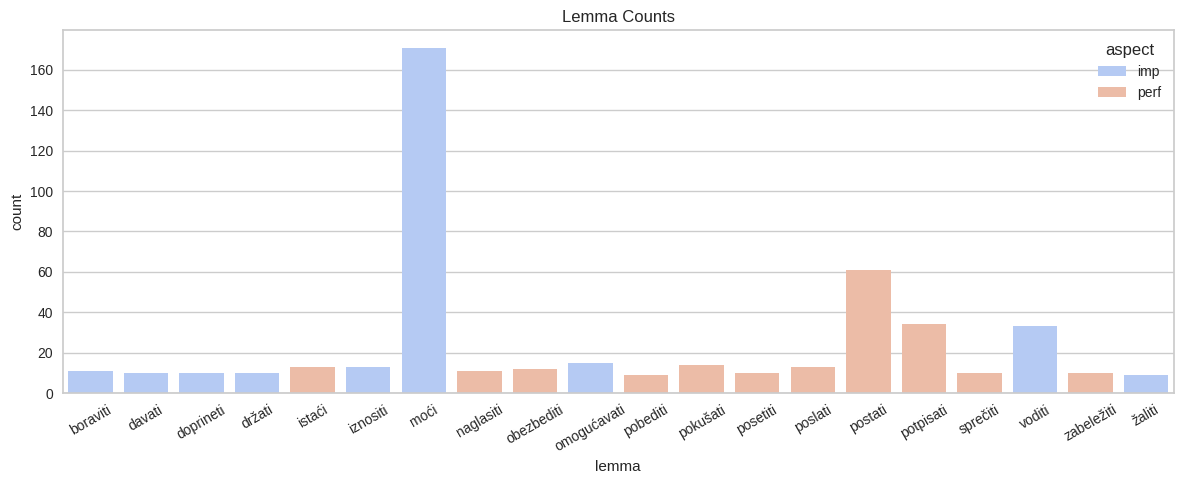

In [21]:
plot_freqs(test_df_unkn, "lemma", "aspect")

In [24]:
test_df_unkn["aspect"].value_counts()

aspect
imp     305
perf    245
Name: count, dtype: int64

In [25]:
y_test_unkn = test_df_unkn[target_vars]
X_test_unkn = test_df_unkn.drop(target_vars, axis=1)
X_test_unkn.shape, y_test_unkn.shape

((550, 32), (550, 2))

In [26]:
X_train, X_test_holdout, y_train, y_test_holdout = train_test_split(
    train_df.drop(target_vars, axis=1),
    train_df[target_vars],
    test_size=0.1247,
    random_state=RANDOM_STATE,
    shuffle=True
)
X_train.shape, X_test_holdout.shape, y_train.shape, y_test_holdout.shape

((3859, 32), (550, 32), (3859, 2), (550, 2))

### Наивный эксперимент: категориальные фичи

In [24]:
X_train_naieve, X_test_holdout_naieve, X_test_unkn_naieve = one_hot_encode(
    X_train[grapheme_vars + grammar_vars],
    X_test_holdout[grapheme_vars + grammar_vars],
    X_test_unkn[grapheme_vars + grammar_vars],
)

In [25]:
X_train_naieve.shape, X_test_holdout_naieve.shape, X_test_unkn_naieve.shape

((3859, 166), (550, 166), (550, 166))


--- Naieve categorical: LGBMClassifier ---
 

F1 weighted (Holdout): 0.964 

F1 weighted (Unknown): 0.611 

CV F1: 0.969 

Holdout confusion matrix 

[[ 19   0   0]
 [  0 246  15]
 [  0   5 265]] 

Unknown confusion matrix 

[[171 134]
 [ 80 165]] 

Holdout report: 

              precision    recall  f1-score   support

        both       1.00      1.00      1.00        19
         imp       0.98      0.94      0.96       261
        perf       0.95      0.98      0.96       270

    accuracy                           0.96       550
   macro avg       0.98      0.97      0.97       550
weighted avg       0.96      0.96      0.96       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.68      0.56      0.62       305
        perf       0.55      0.67      0.61       245

    accuracy                           0.61       550
   macro avg       0.62      0.62      0.61       550
weighted avg       0.62      0.61      0.61       550
 



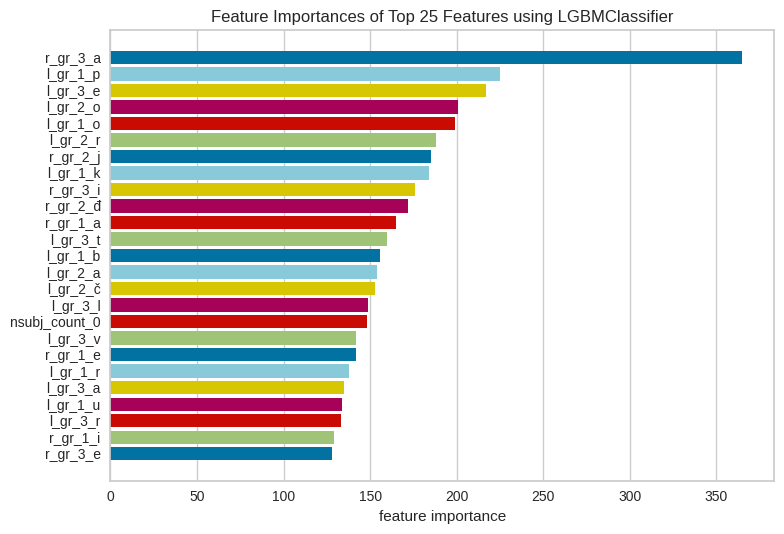

In [26]:
experiment(
    "Naieve categorical",
    "---",
    lambda: LGBMClassifier(verbose=-1, random_state=RANDOM_STATE),
    X_train_naieve,
    X_test_holdout_naieve,
    X_test_unkn_naieve,
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    log=None,
    report=True,
    fi=True,
    cv=True,
    confusion=True,
)

### Модели

In [27]:
get_regression = lambda: LogisticRegression(
    max_iter=200
)

get_dt = lambda: DecisionTreeClassifier(
    random_state=RANDOM_STATE
)

get_lgbm = lambda: LGBMClassifier(
    random_state=RANDOM_STATE,
    verbose=-1
)

get_nn = lambda: MLPClassifier(
    random_state=RANDOM_STATE,
    hidden_layer_sizes=(100, 50, 25),
    alpha=0.0001,
    max_iter=200
)

models = [get_regression, get_dt, get_lgbm, get_nn]

In [28]:
experiments = [
    lambda model: experiment(
        "all categorical",
        "Naieve",
        model,
        *one_hot_encode(
            X_train[grapheme_vars + grammar_vars],
            X_test_holdout[grapheme_vars + grammar_vars],
            X_test_unkn[grapheme_vars + grammar_vars],
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "all categorical PCA",
        "Naieve",
        model,
        *onehot_and_pca(
            20,
            X_train[grapheme_vars + grammar_vars],
            X_test_holdout[grapheme_vars + grammar_vars],
            X_test_unkn[grapheme_vars + grammar_vars],
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
]

In [29]:
for e in experiments:
    for model in models:
        e(model)


--- all categorical: LogisticRegression ---
 

F1 weighted (Holdout): 0.894 

F1 weighted (Unknown): 0.829 

CV F1: 0.902 


--- all categorical: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.962 

F1 weighted (Unknown): 0.733 

CV F1: 0.952 


--- all categorical: LGBMClassifier ---
 

F1 weighted (Holdout): 0.964 

F1 weighted (Unknown): 0.611 

CV F1: 0.969 


--- all categorical: MLPClassifier ---
 

F1 weighted (Holdout): 0.965 

F1 weighted (Unknown): 0.696 

CV F1: 0.959 


--- all categorical PCA: LogisticRegression ---
 

F1 weighted (Holdout): 0.800 

F1 weighted (Unknown): 0.701 

CV F1: 0.783 


--- all categorical PCA: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.865 

F1 weighted (Unknown): 0.569 

CV F1: 0.852 


--- all categorical PCA: LGBMClassifier ---
 

F1 weighted (Holdout): 0.913 

F1 weighted (Unknown): 0.722 

CV F1: 0.891 


--- all categorical PCA: MLPClassifier ---
 

F1 weighted (Holdout): 0.920 

F1 weighted (Unknown): 0.646 

CV F1: 0.

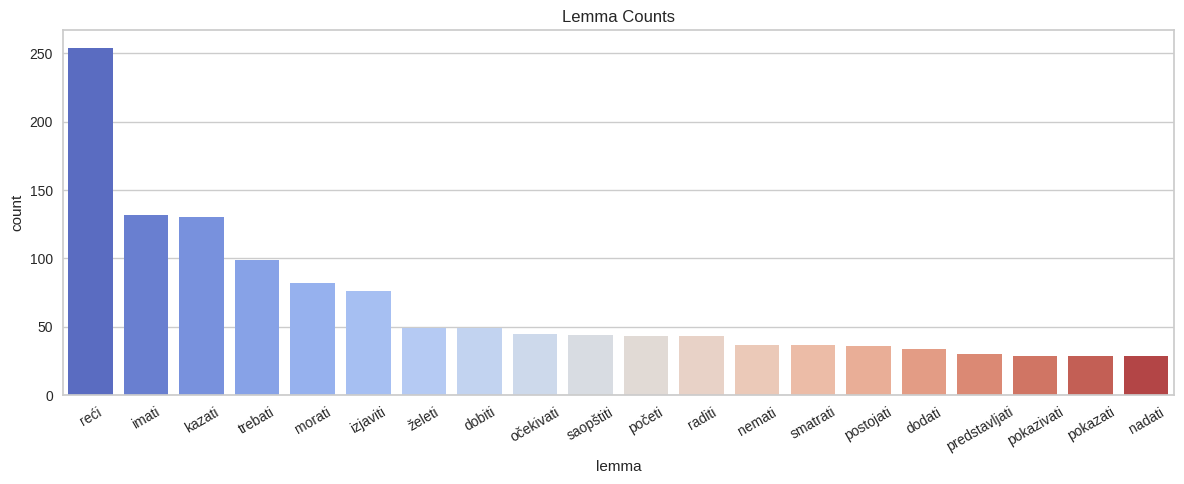

In [30]:
plot_freqs(X_train, "lemma")

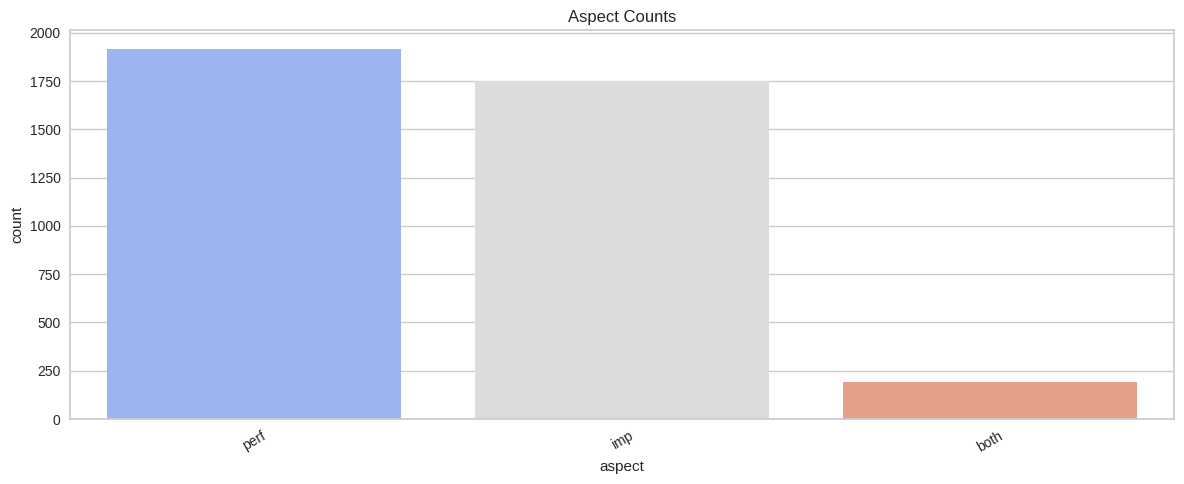

In [31]:
plot_freqs(y_train, "aspect")

### Эксперименты с графемами

In [ ]:
X_train_graphemes          = X_train         [grapheme_vars]
X_test_holdout_graphemes   = X_test_holdout  [grapheme_vars]
X_test_unkn_graphemes      = X_test_unkn     [grapheme_vars]

X_train_graphemes.head()

,l_gr_1,l_gr_2,l_gr_3,r_gr_1,r_gr_2,r_gr_3
1898,o,d,r,i,l,a
3998,s,p,r,e,d,e
2987,p,o,š,e,j,u
4256,u,b,i,o,i,b
4506,u,č,e,a,l,a


In [ ]:
X_train_graphemes_2 = X_train_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_test_holdout_graphemes_2 = X_test_holdout_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_test_unkn_graphemes_2 = X_test_unkn_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)

X_train_graphemes_2.head()

,l_gr_1,l_gr_2,r_gr_1,r_gr_2
1898,o,d,i,l
3998,s,p,e,d
2987,p,o,e,j
4256,u,b,o,i
4506,u,č,a,l


In [ ]:
X_train_graphemes_1 = X_train_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_test_holdout_graphemes_1 = X_test_holdout_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_test_unkn_graphemes_1 = X_test_unkn_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)

X_train_graphemes_1.head()

,l_gr_1,r_gr_1
1898,o,i
3998,s,e
2987,p,e
4256,u,o
4506,u,a


In [ ]:
X_train_sufs = pd.DataFrame()
X_test_holdout_sufs = pd.DataFrame()
X_test_unkn_sufs = pd.DataFrame()

X_train_sufs["pref"] = X_train_graphemes["l_gr_1"] + X_train_graphemes["l_gr_2"] + X_train_graphemes["l_gr_3"]
X_train_sufs["suf"] = X_train_graphemes["r_gr_1"] + X_train_graphemes["r_gr_2"] + X_train_graphemes["r_gr_3"]

X_test_holdout_sufs["pref"] = X_test_holdout_graphemes["l_gr_1"] + X_test_holdout_graphemes["l_gr_2"] + X_test_holdout_graphemes["l_gr_3"]
X_test_holdout_sufs["suf"] = X_test_holdout_graphemes["r_gr_1"] + X_test_holdout_graphemes["r_gr_2"] + X_test_holdout_graphemes["r_gr_3"]

X_test_unkn_sufs["pref"] = X_test_unkn_graphemes["l_gr_1"] + X_test_unkn_graphemes["l_gr_2"] + X_test_unkn_graphemes["l_gr_3"]
X_test_unkn_sufs["suf"] = X_test_unkn_graphemes["r_gr_1"] + X_test_unkn_graphemes["r_gr_2"] + X_test_unkn_graphemes["r_gr_3"]

X_train_sufs.head()

,pref,suf
1898,odr,ila
3998,spr,ede
2987,poš,eju
4256,ubi,oib
4506,uče,ala


In [41]:
X_train_sufs.nunique()

pref    205
suf     250
dtype: int64

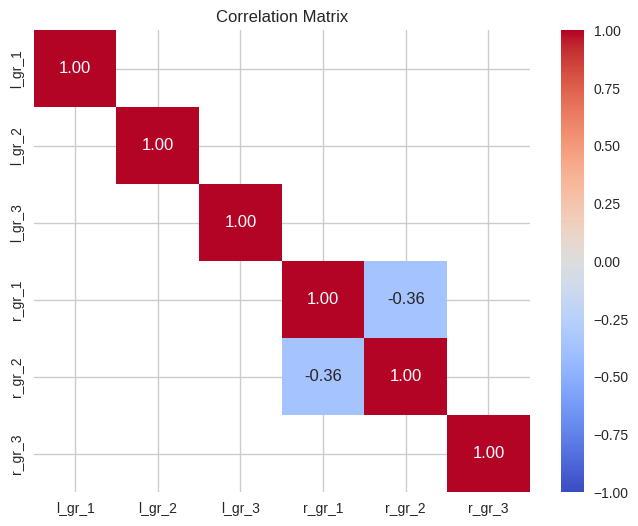

In [42]:
plot_corr(X_train_graphemes)

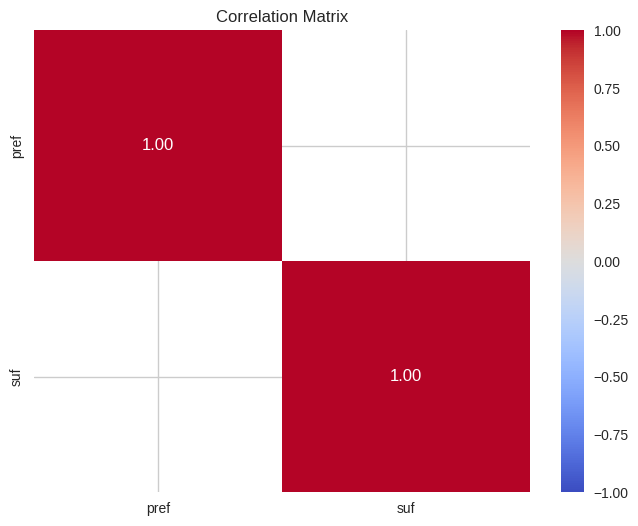

In [43]:
plot_corr(X_train_sufs)

In [44]:
experiments = [
    lambda model: experiment(
        "6_graphemes",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_graphemes,
            X_test_holdout_graphemes,
            X_test_unkn_graphemes,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "4_graphemes",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_graphemes_2,
            X_test_holdout_graphemes_2,
            X_test_unkn_graphemes_2,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "2_graphemes",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_graphemes_1,
            X_test_holdout_graphemes_1,
            X_test_unkn_graphemes_1,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "sufs",
        "Graphemes",
        model,
        *one_hot_encode(
            X_train_sufs,
            X_test_holdout_sufs,
            X_test_unkn_sufs,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),

    lambda model: experiment(
        "6_graphemes PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes,
            X_test_holdout_graphemes,
            X_test_unkn_graphemes,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
    lambda model: experiment(
        "4_graphemes PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes_2,
            X_test_holdout_graphemes_2,
            X_test_unkn_graphemes_2,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
    lambda model: experiment(
        "2_graphemes PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes_1,
            X_test_holdout_graphemes_1,
            X_test_unkn_graphemes_1,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
    lambda model: experiment(
        "sufs PCA",
        "Graphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_sufs,
            X_test_holdout_sufs,
            X_test_unkn_sufs,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True
    ),
]

In [45]:
# 6 min 20 sec
for e in experiments:
    for model in models:
        e(model)


--- 6_graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.873 

F1 weighted (Unknown): 0.818 

CV F1: 0.889 


--- 6_graphemes: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.953 

F1 weighted (Unknown): 0.519 

CV F1: 0.960 


--- 6_graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.967 

F1 weighted (Unknown): 0.596 

CV F1: 0.972 


--- 6_graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.971 

F1 weighted (Unknown): 0.748 

CV F1: 0.974 


--- 4_graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.838 

F1 weighted (Unknown): 0.882 

CV F1: 0.862 


--- 4_graphemes: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.911 

F1 weighted (Unknown): 0.832 

CV F1: 0.907 


--- 4_graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.920 

F1 weighted (Unknown): 0.808 

CV F1: 0.914 


--- 4_graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.920 

F1 weighted (Unknown): 0.826 

CV F1: 0.920 


--- 2_graphemes: LogisticRegression ---
 

In [46]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
0,all categorical,Naieve,LogisticRegression,False,0.902,0.894,0.829
1,all categorical,Naieve,DecisionTreeClassifier,False,0.952,0.962,0.733
2,all categorical,Naieve,LGBMClassifier,False,0.969,0.964,0.611
3,all categorical,Naieve,MLPClassifier,False,0.959,0.965,0.696
4,all categorical PCA,Naieve,LogisticRegression,True,0.783,0.800,0.701


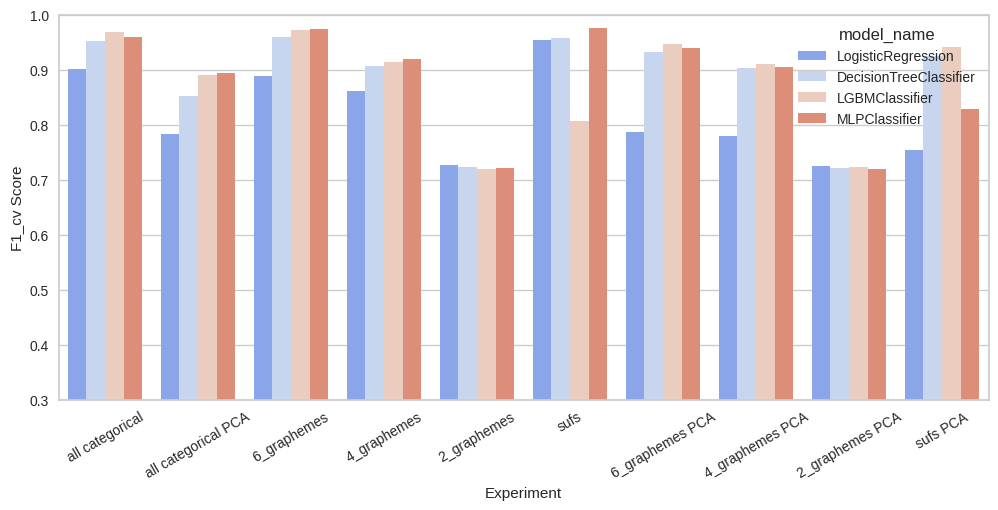

In [47]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

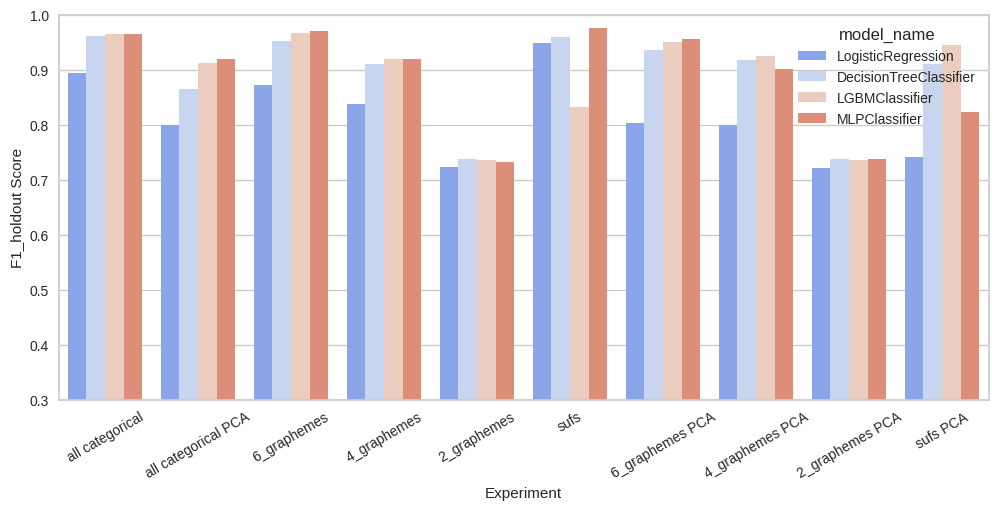

In [48]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

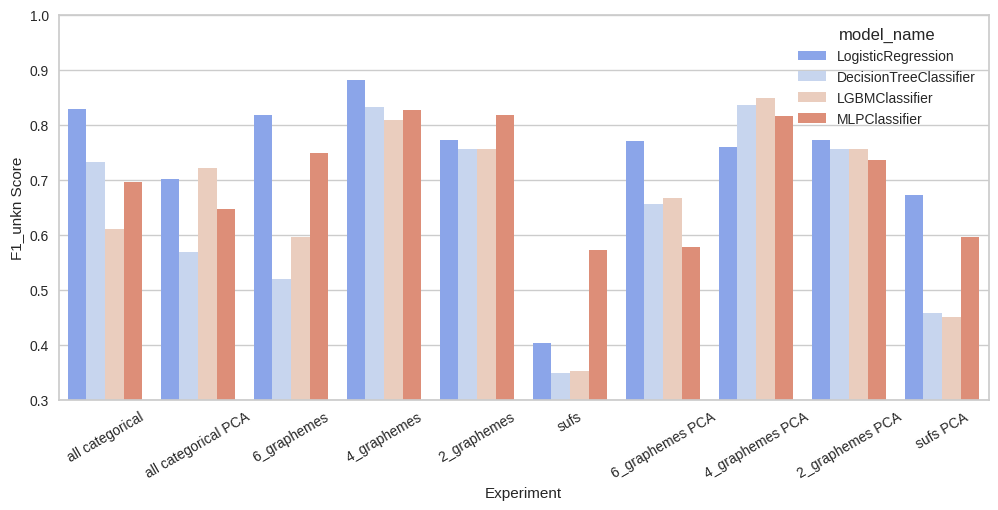

In [49]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [50]:
scores_df.loc[scores_df["F1_unkn"].idxmax()]

experiment_name            4_graphemes
experiment_group             Graphemes
model_name          LogisticRegression
PCA                              False
F1_cv                            0.862
F1_holdout                       0.838
F1_unkn                          0.882
Name: 12, dtype: object

In [51]:
X_train_graphemes_2_oh, X_test_holdout_graphemes_2_oh, X_test_unkn_graphemes_2_oh = one_hot_encode(
    X_train_graphemes_2,
    X_test_holdout_graphemes_2,
    X_test_unkn_graphemes_2,
)

In [52]:
# param_grid = {
#     "penalty"     : ["elasticnet"],
#     "C"           : [0.001, 0.01, 0.1, 1, 10, 100],
#     "solver"      : ["saga"],
#     "max_iter"    : [100, 200, 500],
#     "class_weight": [None, "balanced"],
#     "l1_ratio"    : [0.0, 0.1, 0.5, 0.9, 1.0],
#     "verbose"     : [0]
# }

In [53]:
# grid_search = GridSearchCV(
#     LogisticRegression(),
#     param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1,
#     verbose=0
# )
# grid_search.fit(X_train_graphemes_2_oh, y_train["aspect"])
# grid_search.best_score_

In [54]:
# best_params = grid_search.best_params_
best_params = {'C': 10,
 'class_weight': None,
 'l1_ratio': 0.1,
 'max_iter': 100,
 'penalty': 'elasticnet',
 'solver': 'saga',
 'verbose': 0}


--- 2_graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.838 

F1 weighted (Unknown): 0.878 

CV F1: 0.864 

Holdout confusion matrix 

[[ 14   2   3]
 [  0 209  52]
 [  3  29 238]] 

Unknown confusion matrix 

[[270  35]
 [ 32 213]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.82      0.74      0.78        19
         imp       0.87      0.80      0.83       261
        perf       0.81      0.88      0.85       270

    accuracy                           0.84       550
   macro avg       0.84      0.81      0.82       550
weighted avg       0.84      0.84      0.84       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.89      0.89      0.89       305
        perf       0.86      0.87      0.86       245

    accuracy                           0.88       550
   macro avg       0.88      0.88      0.88       550
weighted avg       0.88      0.88      0.88       550
 



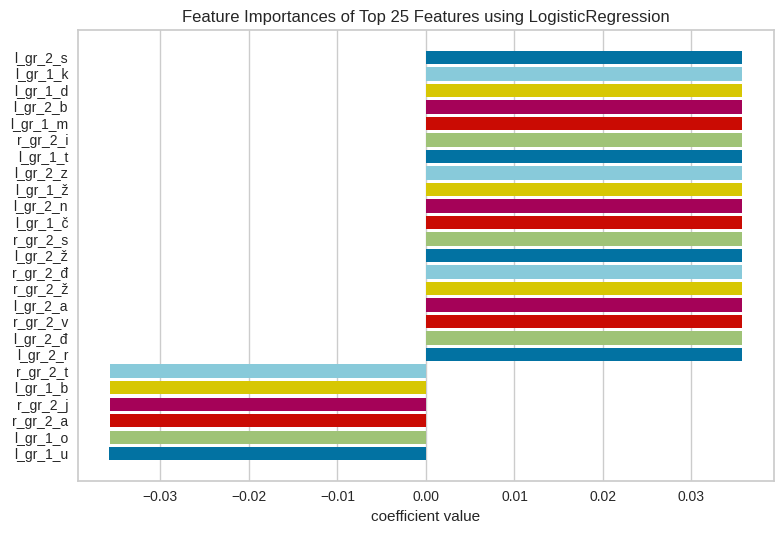

(None,)

In [55]:
experiment(
    "2_graphemes",
    "---",
    lambda: LogisticRegression(**best_params),
    X_train_graphemes_2_oh,
    X_test_holdout_graphemes_2_oh,
    X_test_unkn_graphemes_2_oh,
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
),

### Эксперименты с грамматикой

In [56]:
X_train_grammar = X_train[grammar_vars]
X_test_holdout_grammar = X_test_holdout[grammar_vars]
X_test_unkn_grammar = X_test_unkn[grammar_vars]

In [57]:
X_train_grammar.shape

(3859, 12)

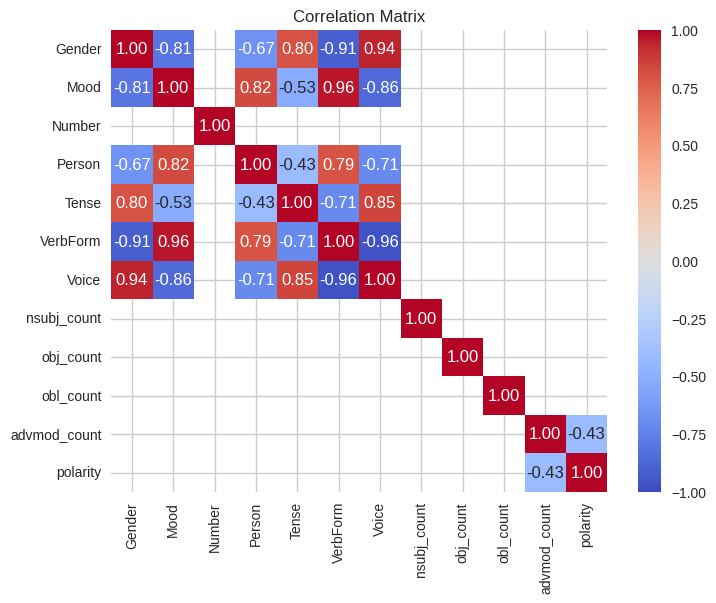

In [58]:
plot_corr(X_train_grammar)

In [59]:
categories = ["Gender", "Mood", "Number", "Person", "Tense", "VerbForm", "Voice"]

In [60]:
X_train_grammar_only_categories = X_train_grammar[categories]
X_test_holdout_grammar_only_categories = X_test_holdout_grammar[categories]
X_test_unkn_grammar_only_categories = X_test_unkn_grammar[categories]

X_train_grammar_no_categories = X_train_grammar.drop(categories, axis=1)
X_test_holdout_grammar_no_categories = X_test_holdout_grammar.drop(categories, axis=1)
X_test_unkn_grammar_no_categories = X_test_unkn_grammar.drop(categories, axis=1)

In [61]:
X_train_grammar_only_categories.shape, X_train_grammar_no_categories.shape

((3859, 7), (3859, 5))

In [62]:
experiments = [
    lambda model: experiment(
        "all grammar",
        "Grammar",
        model,
        *one_hot_encode(
            X_train_grammar,
            X_test_holdout_grammar,
            X_test_unkn_grammar,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "only categories grammar",
        "Grammar",
        model,
        *one_hot_encode(
            X_train_grammar_only_categories,
            X_test_holdout_grammar_only_categories,
            X_test_unkn_grammar_only_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "no categories grammar",
        "Grammar",
        model,
        *one_hot_encode(
            X_train_grammar_no_categories,
            X_test_holdout_grammar_no_categories,
            X_test_unkn_grammar_no_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "all grammar PCA",
        "Grammar",
        model,
        *onehot_and_pca(
            6,
            X_train_grammar,
            X_test_holdout_grammar,
            X_test_unkn_grammar,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
    lambda model: experiment(
        "only categories grammar PCA",
        "Grammar",
        model,
        *onehot_and_pca(
            6,
            X_train_grammar_only_categories,
            X_test_holdout_grammar_only_categories,
            X_test_unkn_grammar_only_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
    lambda model: experiment(
        "no categories grammar PCA",
        "Grammar",
        model,
        *onehot_and_pca(
            6,
            X_train_grammar_no_categories,
            X_test_holdout_grammar_no_categories,
            X_test_unkn_grammar_no_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
        pca=True,
    ),
]

In [63]:
# 3 min 20 sec
for e in experiments:
    for model in models:
        e(model)


--- all grammar: LogisticRegression ---
 

F1 weighted (Holdout): 0.736 

F1 weighted (Unknown): 0.689 

CV F1: 0.706 


--- all grammar: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.738 

F1 weighted (Unknown): 0.699 

CV F1: 0.705 


--- all grammar: LGBMClassifier ---
 

F1 weighted (Holdout): 0.742 

F1 weighted (Unknown): 0.699 

CV F1: 0.713 


--- all grammar: MLPClassifier ---
 

F1 weighted (Holdout): 0.740 

F1 weighted (Unknown): 0.702 

CV F1: 0.708 


--- only categories grammar: LogisticRegression ---
 

F1 weighted (Holdout): 0.743 

F1 weighted (Unknown): 0.693 

CV F1: 0.711 


--- only categories grammar: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.738 

F1 weighted (Unknown): 0.701 

CV F1: 0.713 


--- only categories grammar: LGBMClassifier ---
 

F1 weighted (Holdout): 0.738 

F1 weighted (Unknown): 0.701 

CV F1: 0.714 


--- only categories grammar: MLPClassifier ---
 

F1 weighted (Holdout): 0.738 

F1 weighted (Unknown): 0.701 

CV F1: 0.

In [140]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["Grammar"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
40,all grammar,Grammar,LogisticRegression,False,0.706,0.736,0.689
41,all grammar,Grammar,DecisionTreeClassifier,False,0.705,0.738,0.699
42,all grammar,Grammar,LGBMClassifier,False,0.713,0.742,0.699
43,all grammar,Grammar,MLPClassifier,False,0.708,0.740,0.702
44,only categories grammar,Grammar,LogisticRegression,False,0.711,0.743,0.693


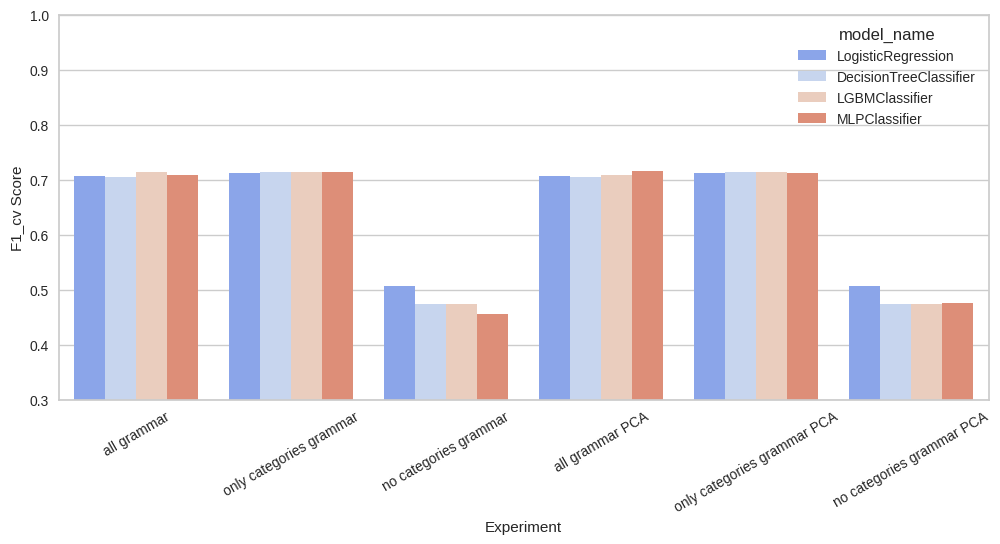

In [141]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

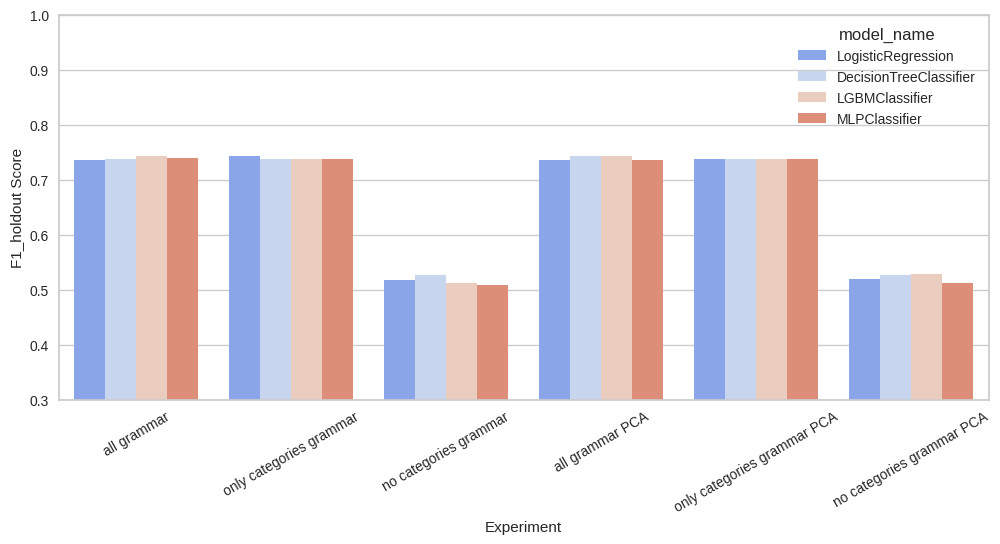

In [142]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

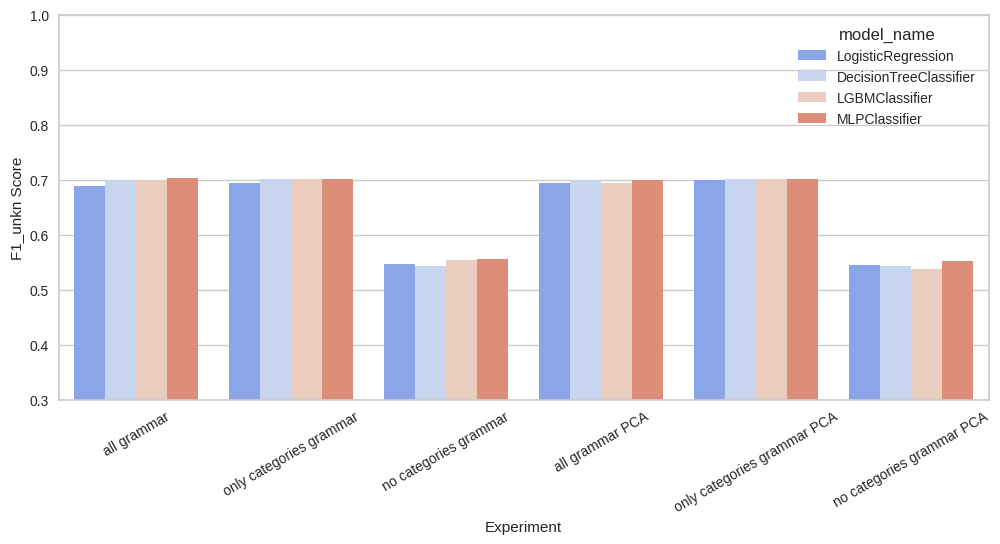

In [143]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)


--- only categories grammar: LGBMClassifier ---
 

F1 weighted (Holdout): 0.738 

F1 weighted (Unknown): 0.701 

Holdout confusion matrix 

[[  0  16   3]
 [  0 211  50]
 [  0  68 202]] 

Unknown confusion matrix 

[[198 107]
 [ 58 187]] 

Holdout report: 

              precision    recall  f1-score   support

        both       1.00      0.00      0.00        19
         imp       0.72      0.81      0.76       261
        perf       0.79      0.75      0.77       270

    accuracy                           0.75       550
   macro avg       0.84      0.52      0.51       550
weighted avg       0.76      0.75      0.74       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.77      0.65      0.71       305
        perf       0.64      0.76      0.69       245

    accuracy                           0.70       550
   macro avg       0.70      0.71      0.70       550
weighted avg       0.71      0.70      0.70       550
 



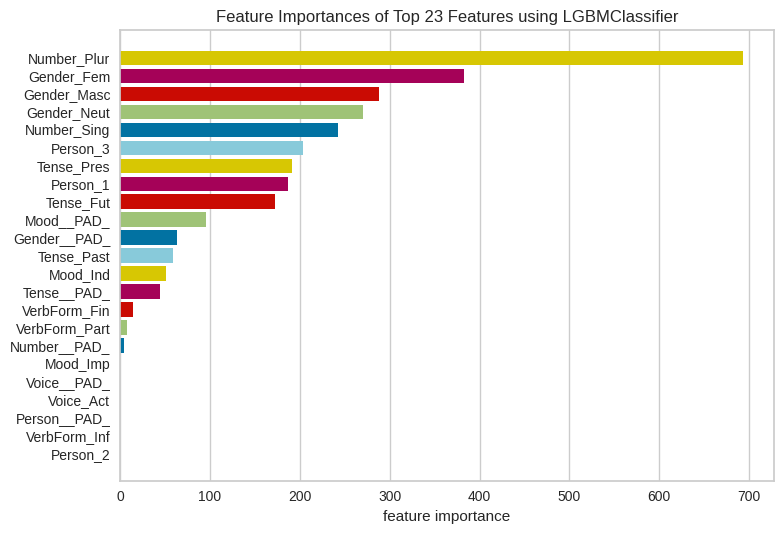

In [68]:
experiment(
    "only categories grammar",
    "---",
    get_lgbm,
    *one_hot_encode(
        X_train_grammar_only_categories,
        X_test_holdout_grammar_only_categories,
        X_test_unkn_grammar_only_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=False,
    log=None,
    fi=True,
    report=True,
    confusion=True
)


--- only categories grammar: LogisticRegression ---
 

F1 weighted (Holdout): 0.743 

F1 weighted (Unknown): 0.693 

Holdout confusion matrix 

[[  0  15   4]
 [  0 209  52]
 [  0  63 207]] 

Unknown confusion matrix 

[[195 110]
 [ 59 186]] 

Holdout report: 

              precision    recall  f1-score   support

        both       1.00      0.00      0.00        19
         imp       0.73      0.80      0.76       261
        perf       0.79      0.77      0.78       270

    accuracy                           0.76       550
   macro avg       0.84      0.52      0.51       550
weighted avg       0.77      0.76      0.74       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.77      0.64      0.70       305
        perf       0.63      0.76      0.69       245

    accuracy                           0.69       550
   macro avg       0.70      0.70      0.69       550
weighted avg       0.71      0.69      0.69       550
 



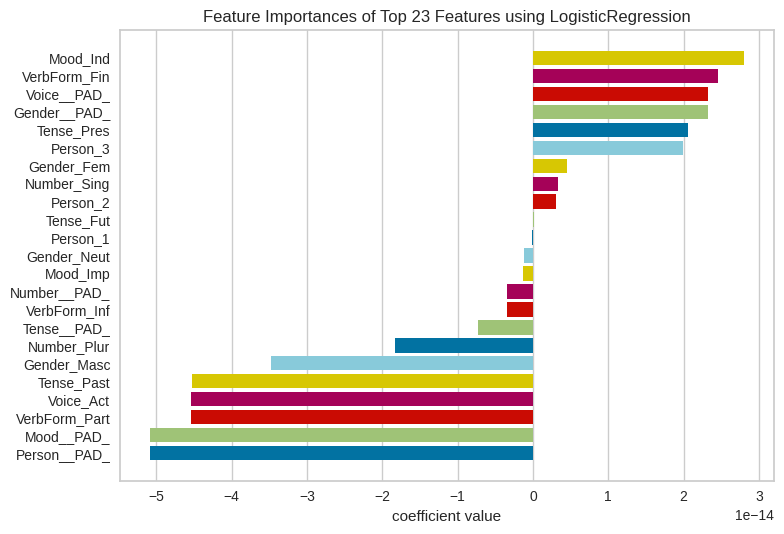

In [69]:
experiment(
    "only categories grammar",
    "---",
    get_regression,
    *one_hot_encode(
        X_train_grammar_only_categories,
        X_test_holdout_grammar_only_categories,
        X_test_unkn_grammar_only_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=False,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

In [70]:
# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "n_estimators": [30, 50, 100],
#     "max_depth": [3, 7, -1],
#     "num_leaves": [15, 30, 60, 120],
#     "subsample": [0.6, 0.8, 1.0],
#     "verbose": [-1]
# }

In [71]:
# X_train_grammar_only_categories_oh, X_test_holdout_grammar_only_categories_oh, X_test_unkn_grammar_only_categories_oh = one_hot_encode(
#     X_train_grammar_only_categories,
#     X_test_holdout_grammar_only_categories,
#     X_test_unkn_grammar_only_categories,
# )

In [72]:
# grid_search = GridSearchCV(
#     LGBMClassifier(),
#     param_grid,
#     cv=5,
#     scoring="accuracy",
#     n_jobs=-1,
#     verbose=0
# )
# grid_search.fit(X_train_grammar_only_categories_oh, y_train["aspect"])
# grid_search.best_score_, grid_search.best_params_

### Совмещаем грамматику и графемы.

In [73]:
X_train_graphemes_2.columns.to_list()

['l_gr_1', 'l_gr_2', 'r_gr_1', 'r_gr_2']

In [74]:
X_train_graphemes_and_grammar_categories = X_train[
    X_train_graphemes_2.columns.to_list() + X_train_grammar_only_categories.columns.to_list()
]
X_train_graphemes_and_grammar_categories.head()

,l_gr_1,l_gr_2,r_gr_1,r_gr_2,Gender,Mood,Number,Person,Tense,VerbForm,Voice
1898,o,d,i,l,Masc,[PAD],Plur,[PAD],Past,Part,Act
3998,s,p,e,d,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
2987,p,o,e,j,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
4256,u,b,o,i,Masc,[PAD],Sing,[PAD],Past,Part,Act
4506,u,č,a,l,Fem,[PAD],Sing,[PAD],Past,Part,Act


In [75]:
X_test_holdout_graphemes_and_grammar_categories = X_test_holdout[
    X_train_graphemes_2.columns.to_list() + X_train_grammar_only_categories.columns.to_list()
]

X_test_unkn_graphemes_and_grammar_categories = X_test_unkn[
    X_train_graphemes_2.columns.to_list() + X_train_grammar_only_categories.columns.to_list()
]

In [76]:
# 1 min 30 sec
for model in models:

    experiment(
        "grammar and graphemes",
        "GrammarAndGraphemes",
        model,
        *one_hot_encode(
            X_train_graphemes_and_grammar_categories,
            X_test_holdout_graphemes_and_grammar_categories,
            X_test_unkn_graphemes_and_grammar_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    )

    experiment(
        "grammar and graphemes PCA",
        "GrammarAndGraphemes",
        model,
        *onehot_and_pca(
            20,
            X_train_graphemes_and_grammar_categories,
            X_test_holdout_graphemes_and_grammar_categories,
            X_test_unkn_graphemes_and_grammar_categories,
        ),
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    )


--- grammar and graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.850 

F1 weighted (Unknown): 0.876 

CV F1: 0.863 


--- grammar and graphemes PCA: LogisticRegression ---
 

F1 weighted (Holdout): 0.807 

F1 weighted (Unknown): 0.639 

CV F1: 0.783 


--- grammar and graphemes: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.922 

F1 weighted (Unknown): 0.811 

CV F1: 0.914 


--- grammar and graphemes PCA: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.909 

F1 weighted (Unknown): 0.812 

CV F1: 0.904 


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.927 

F1 weighted (Unknown): 0.828 

CV F1: 0.917 


--- grammar and graphemes PCA: LGBMClassifier ---
 

F1 weighted (Holdout): 0.912 

F1 weighted (Unknown): 0.855 

CV F1: 0.909 


--- grammar and graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.924 

F1 weighted (Unknown): 0.793 

CV F1: 0.923 


--- grammar and graphemes PCA: MLPClassifier ---
 

F1 weighted (Holdout): 

In [85]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["GrammarAndGraphemes", "Naieve"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
0,all categorical,Naieve,LogisticRegression,False,0.902,0.894,0.829
1,all categorical,Naieve,DecisionTreeClassifier,False,0.952,0.962,0.733
2,all categorical,Naieve,LGBMClassifier,False,0.969,0.964,0.611
3,all categorical,Naieve,MLPClassifier,False,0.959,0.965,0.696
4,all categorical PCA,Naieve,LogisticRegression,True,0.783,0.800,0.701


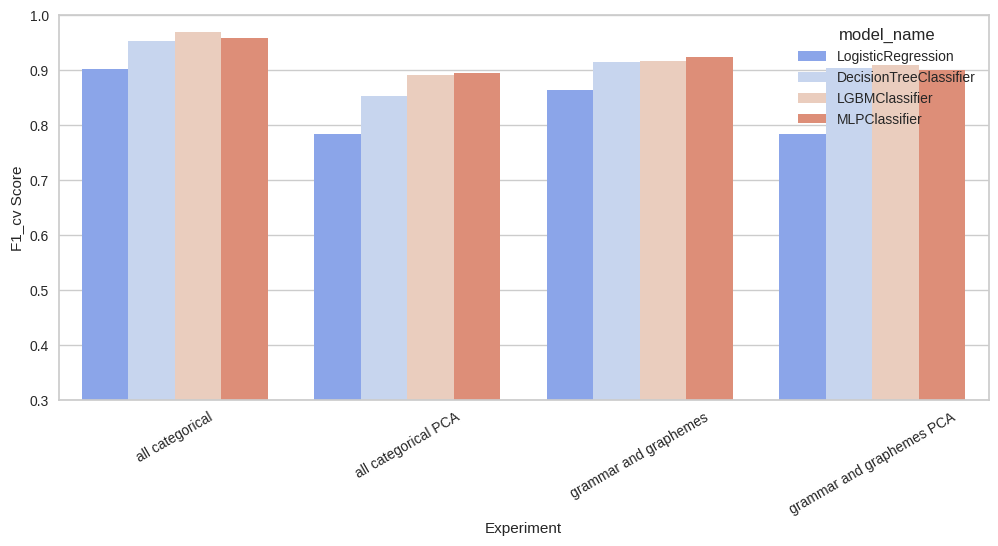

In [86]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

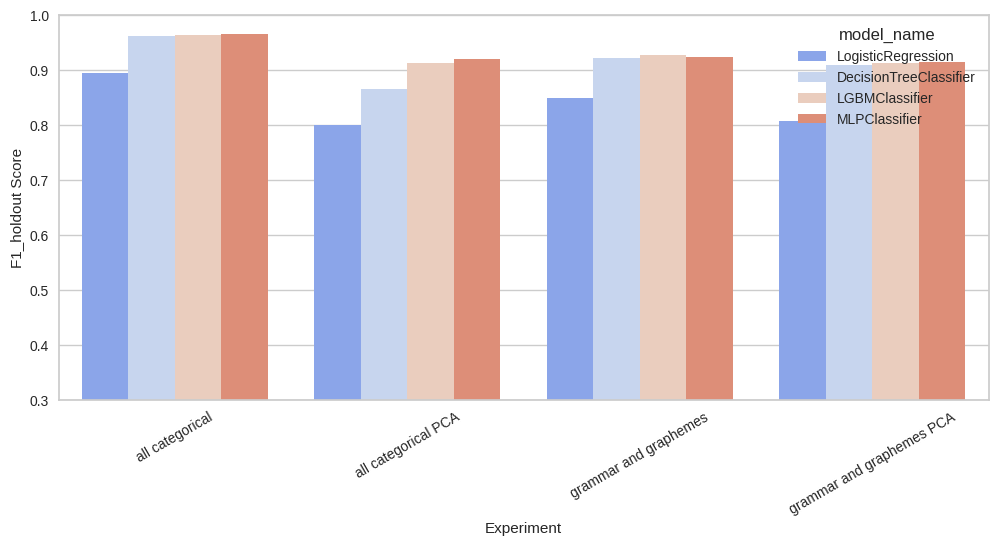

In [87]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

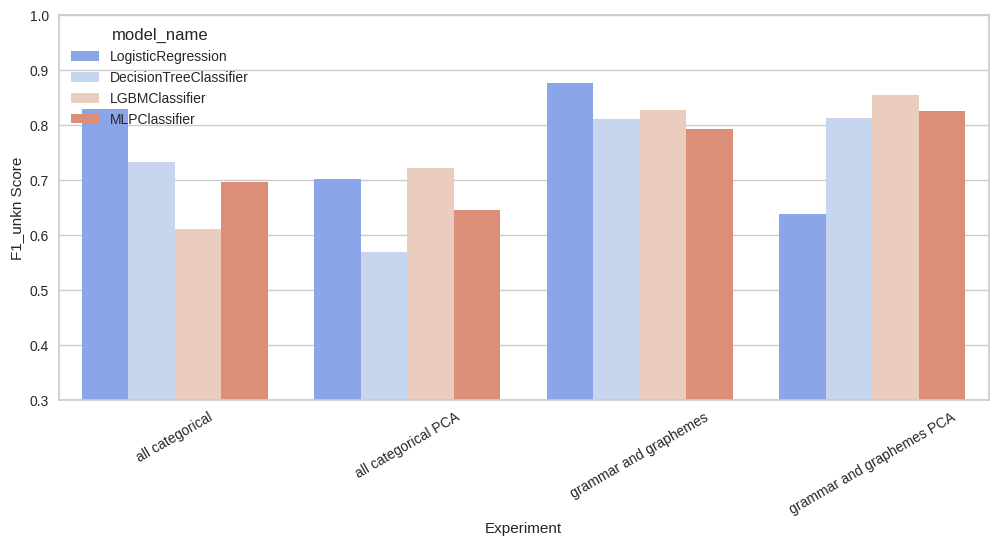

In [88]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.927 

F1 weighted (Unknown): 0.828 

CV F1: 0.917 

Holdout confusion matrix 

[[ 17   2   0]
 [  0 234  27]
 [  2   9 259]] 

Unknown confusion matrix 

[[253  52]
 [ 43 202]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.89      0.89      0.89        19
         imp       0.96      0.90      0.92       261
        perf       0.91      0.96      0.93       270

    accuracy                           0.93       550
   macro avg       0.92      0.92      0.92       550
weighted avg       0.93      0.93      0.93       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.85      0.83      0.84       305
        perf       0.80      0.82      0.81       245

    accuracy                           0.83       550
   macro avg       0.83      0.83      0.83       550
weighted avg       0.83      0.83      0.83       550
 

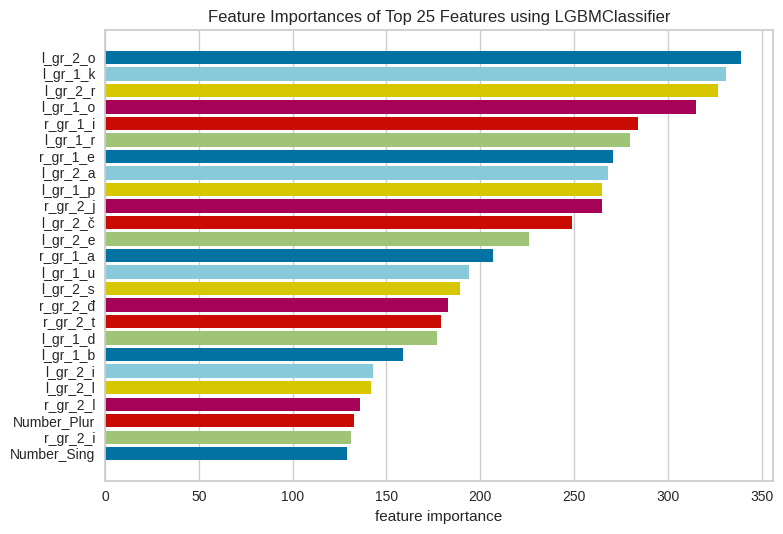

In [89]:
experiment(
    "grammar and graphemes",
    "---",
    get_lgbm,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.885 

F1 weighted (Unknown): 0.759 

CV F1: 0.872 

Holdout confusion matrix 

[[ 16   2   1]
 [  0 227  34]
 [  3  23 244]] 

Unknown confusion matrix 

[[225  80]
 [ 53 192]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.84      0.84      0.84        19
         imp       0.90      0.87      0.88       261
        perf       0.87      0.90      0.89       270

    accuracy                           0.89       550
   macro avg       0.87      0.87      0.87       550
weighted avg       0.89      0.89      0.89       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.81      0.74      0.77       305
        perf       0.71      0.78      0.74       245

    accuracy                           0.76       550
   macro avg       0.76      0.76      0.76       550
weighted avg       0.76      0.76      0.76       550
 

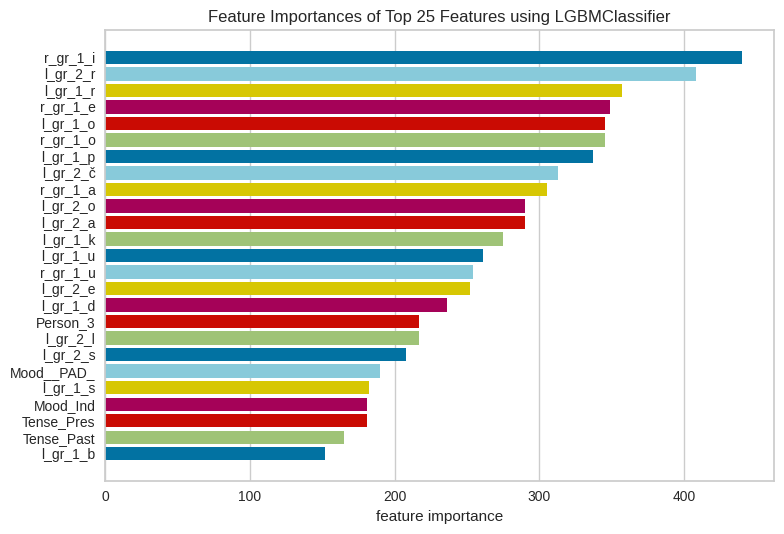

In [94]:
experiment(
    "grammar and graphemes",
    "---",
    get_lgbm,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories.drop(["r_gr_2", "Number", "Gender"], axis=1),
        X_test_holdout_graphemes_and_grammar_categories.drop(["r_gr_2", "Number", "Gender"], axis=1),
        X_test_unkn_graphemes_and_grammar_categories.drop(["r_gr_2", "Number", "Gender"], axis=1),
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)


--- grammar and graphemes: LogisticRegression ---
 

F1 weighted (Holdout): 0.850 

F1 weighted (Unknown): 0.876 

CV F1: 0.863 

Holdout confusion matrix 

[[ 14   2   3]
 [  0 209  52]
 [  3  22 245]] 

Unknown confusion matrix 

[[268  37]
 [ 31 214]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.82      0.74      0.78        19
         imp       0.90      0.80      0.85       261
        perf       0.82      0.91      0.86       270

    accuracy                           0.85       550
   macro avg       0.85      0.82      0.83       550
weighted avg       0.86      0.85      0.85       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.90      0.88      0.89       305
        perf       0.85      0.87      0.86       245

    accuracy                           0.88       550
   macro avg       0.87      0.88      0.88       550
weighted avg       0.88      0.88      0.88       5

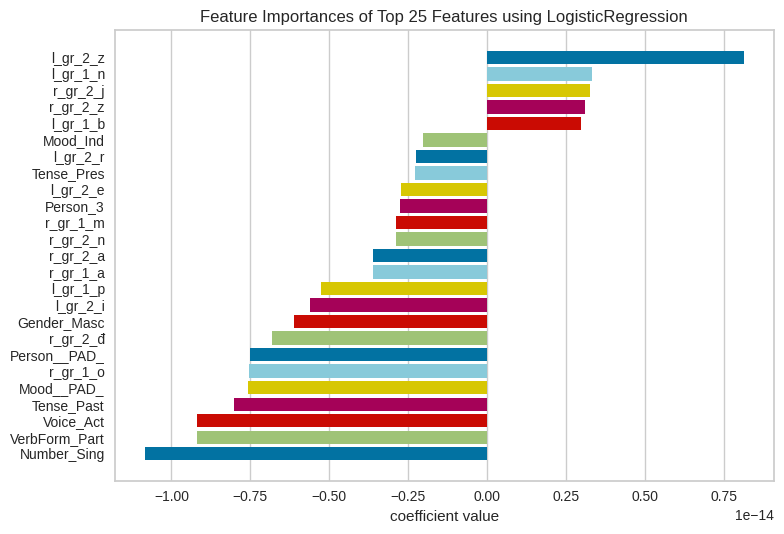

In [92]:
experiment(
    "grammar and graphemes",
    "---",
    get_regression,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

In [ ]:
experiment(
    "grammar and graphemes",
    "---",
    get_nn,
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    # fi=True,
    report=True,
    confusion=True
)


--- grammar and graphemes: MLPClassifier ---
 

F1 weighted (Holdout): 0.924 

F1 weighted (Unknown): 0.793 

CV F1: 0.923 

Holdout confusion matrix 

[[ 16   2   1]
 [  0 240  21]
 [  2  16 252]] 

Unknown confusion matrix 

[[236  69]
 [ 45 200]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.89      0.84      0.86        19
         imp       0.93      0.92      0.92       261
        perf       0.92      0.93      0.93       270

    accuracy                           0.92       550
   macro avg       0.91      0.90      0.91       550
weighted avg       0.92      0.92      0.92       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.84      0.77      0.81       305
        perf       0.74      0.82      0.78       245

    accuracy                           0.79       550
   macro avg       0.79      0.80      0.79       550
weighted avg       0.80      0.79      0.79       550
 


In [131]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [30, 50, 100],
    "max_depth": [3, 5, 7, -1],
    "num_leaves": [15, 30, 60, 100],
    "subsample": [0.6, 0.8, 1.0],
    "verbose": [-1]
}

In [132]:
X_graphemes_and_grammar_categories = one_hot_encode(
    X_train_graphemes_and_grammar_categories,
    X_test_holdout_graphemes_and_grammar_categories,
    X_test_unkn_graphemes_and_grammar_categories,
)

In [133]:
lgb = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=-1,
    num_leaves=15,
    subsample=0.6
)
lgb.fit(
    X_graphemes_and_grammar_categories[0], y_train["aspect"]
)

LGBMClassifier(num_leaves=15, subsample=0.6)

In [134]:
### Почему-то бежит 1 час
# grid_search = GridSearchCV(
#     LGBMClassifier(),
#     param_grid,
#     # cv=5,
#     scoring="accuracy",
#     n_jobs=-1,
#     verbose=0
# )
# grid_search.fit(X_graphemes_and_grammar_categories[0], y_train["aspect"])
# grid_search.best_score_, grid_search.best_params_

In [ ]:
def custom_gridsearch(model:LGBMClassifier, param_grid, X_train, y_train, X_test, y_test):

    keys = param_grid.keys()
    value_combinations = product(*param_grid.values())

    best_metric = 0.0
    best_params = None

    for combination in tqdm(list(value_combinations)):
        params = {
            k: val
            for k, val
            in zip(keys, combination)
        }

        cur_model = model(**params)
        cur_model.fit(X_train, y_train)
        preds= cur_model.predict(X_test)

        f1_wtd = f1_score(y_test, preds, average="weighted")

        if f1_wtd > best_metric:
            best_metric = f1_wtd
            best_params = params

    return best_params, best_metric

In [ ]:
# best_params, metric = custom_gridsearch(
#     LGBMClassifier,
#     param_grid,
#     X_graphemes_and_grammar_categories[0],
#     y_train["aspect"],
#     X_graphemes_and_grammar_categories[-1],
#     y_test_unkn["aspect"]
# )
# best_params, metric

100%|██████████| 576/576 [01:09<00:00,  8.31it/s]


({'learning_rate': 0.05,
  'n_estimators': 50,
  'max_depth': -1,
  'num_leaves': 30,
  'subsample': 0.6,
  'verbose': -1},
 0.8803566453050989)

In [137]:
best_params = {'learning_rate': 0.05,
  'n_estimators': 50,
  'max_depth': -1,
  'num_leaves': 30,
  'subsample': 0.6,
  'verbose': -1}


--- grammar and graphemes: LGBMClassifier ---
 

F1 weighted (Holdout): 0.896 

F1 weighted (Unknown): 0.880 

CV F1: 0.888 

Holdout confusion matrix 

[[ 16   3   0]
 [  0 224  37]
 [  3  14 253]] 

Unknown confusion matrix 

[[258  47]
 [ 19 226]] 

Holdout report: 

              precision    recall  f1-score   support

        both       0.84      0.84      0.84        19
         imp       0.93      0.86      0.89       261
        perf       0.87      0.94      0.90       270

    accuracy                           0.90       550
   macro avg       0.88      0.88      0.88       550
weighted avg       0.90      0.90      0.90       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.93      0.85      0.89       305
        perf       0.83      0.92      0.87       245

    accuracy                           0.88       550
   macro avg       0.88      0.88      0.88       550
weighted avg       0.89      0.88      0.88       550
 

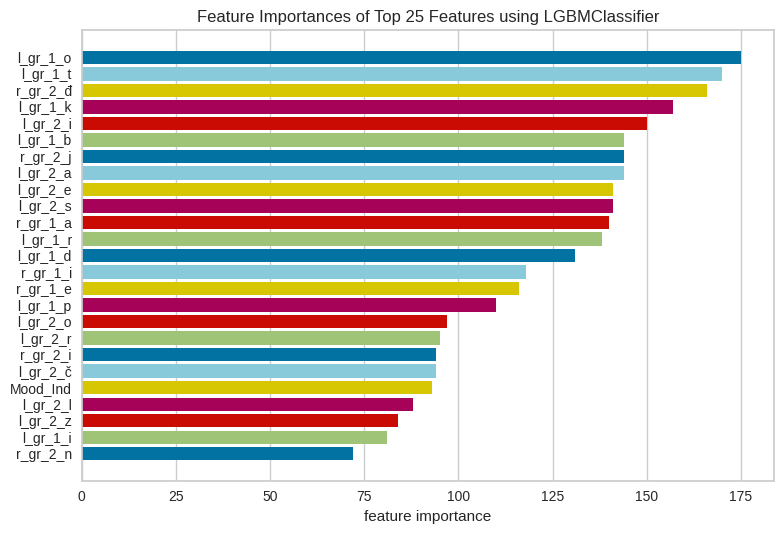

In [138]:
experiment(
    "grammar and graphemes",
    "---",
    lambda: LGBMClassifier(**best_params),
    *one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    ),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

### Текстовые фичи

In [165]:
class Encoder:

    def __init__(self, path_to_model):
        self.model = Word2Vec.load(path_to_model)
        self.ndim = self.model.wv.word_vec("krastavac").shape[0]

    def encode(self, text: str):
        tokens = word_tokenize(text)

        vecs = [
            self.model.wv.word_vec(token)
            for token
            in tokens
            if token in self.model.wv.key_to_index
        ]

        if vecs:
            return np.mean(vecs, axis=0)
        else:
            return np.zeros((self.ndim,))


In [166]:
encoder = Encoder(str(Path.cwd() / "SrW2V" / "TeslaW2V"))

In [167]:
encoder.encode("Nisam bio")

array([ 8.47340345e-01, -1.24501288e-01,  4.86958170e+00, -1.34273803e+00,
       -2.97086954e+00,  3.71142268e+00,  2.43387508e+00,  3.85181069e+00,
       -2.95421219e+00,  3.34436417e-01, -1.58875257e-01, -1.58686471e+00,
       -1.28946507e+00, -3.01051617e-01,  9.45121050e-01,  1.77668595e+00,
        5.86993098e-01, -1.22962356e+00,  2.33354139e+00, -3.38673544e+00,
       -1.20569634e+00, -2.75937104e+00, -5.83984470e+00,  1.30355811e+00,
       -4.45962906e+00,  1.23837054e-01, -4.12644053e+00,  3.44431496e+00,
       -2.49842501e+00, -6.92725182e-03, -1.94456697e-01, -3.43638372e+00,
       -2.82443762e-02,  8.21025610e-01, -2.22832203e+00, -3.07466745e+00,
        2.21040154e+00,  8.69077206e-01,  1.93974113e+00,  1.94455415e-01,
        1.29528332e+00,  4.54815626e+00,  6.07638001e-01,  1.40939832e-01,
        4.75796402e-01,  3.91436172e+00, -1.04877102e+00,  5.56937504e+00,
       -4.74003887e+00,  4.52731252e-01, -3.81715775e+00, -4.98578358e+00,
       -3.72529936e+00,  

In [168]:
encoder.encode("alsdjhja akjdbha")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
X_train_words_encoded = [
    encoder.encode(word)
    for word
    in X_train["word"].values
]

X_test_holdout_words_encoded = [
    encoder.encode(word)
    for word
    in X_test_holdout["word"].values
]

X_test_unkn_words_encoded = [
    encoder.encode(word)
    for word
    in X_test_unkn["word"].values
]

X_train_lemmas_encoded = [
    encoder.encode(word)
    for word
    in X_train["lemma"].values
]

X_test_holdout_lemmas_encoded = [
    encoder.encode(word)
    for word
    in X_test_holdout["lemma"].values
]

X_test_unkn_lemmas_encoded = [
    encoder.encode(word)
    for word
    in X_test_unkn["lemma"].values
]

In [194]:
experiments = [
    lambda model: experiment(
        "word embeddings",
        "W2V",
        model,
        X_train_words_encoded,
        X_test_holdout_words_encoded,
        X_test_unkn_words_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "lemma embeddings",
        "W2V",
        model,
        X_train_lemmas_encoded,
        X_test_holdout_lemmas_encoded,
        X_test_unkn_lemmas_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word and lemma embeddings ",
        "W2V",
        model,
        X_train_lemmas_encoded + X_train_words_encoded,
        X_test_holdout_lemmas_encoded,
        X_test_unkn_lemmas_encoded,
        y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
        y_test_holdout["aspect"].values.tolist(),
        y_test_unkn["aspect"].values.tolist(),
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word and lemma embeddings many",
        "W2V",
        model,
        X_train_lemmas_encoded + X_train_words_encoded + X_train_words_encoded + X_train_words_encoded,
        X_test_holdout_lemmas_encoded,
        X_test_unkn_lemmas_encoded,
        y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
        y_test_holdout["aspect"].values.tolist(),
        y_test_unkn["aspect"].values.tolist(),
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings many",
        "W2V",
        model,
        X_train_words_encoded + X_train_words_encoded + X_train_words_encoded,
        X_test_holdout_words_encoded,
        X_test_unkn_words_encoded,
        y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
        y_test_holdout["aspect"].values.tolist(),
        y_test_unkn["aspect"].values.tolist(),
        cv=True,
        log=LOG,
    ),
]

In [195]:
for e in experiments:
    for model in models:
        e(model)


--- word embeddings: LogisticRegression ---
 

F1 weighted (Holdout): 0.964 

F1 weighted (Unknown): 0.785 

CV F1: 0.944 


--- word embeddings: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.955 

F1 weighted (Unknown): 0.649 

CV F1: 0.934 


--- word embeddings: LGBMClassifier ---
 

F1 weighted (Holdout): 0.985 

F1 weighted (Unknown): 0.935 

CV F1: 0.970 


--- word embeddings: MLPClassifier ---
 

F1 weighted (Holdout): 0.987 

F1 weighted (Unknown): 0.881 

CV F1: 0.980 


--- lemma embeddings: LogisticRegression ---
 

F1 weighted (Holdout): 1.000 

F1 weighted (Unknown): 0.556 

CV F1: 1.000 


--- lemma embeddings: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 1.000 

F1 weighted (Unknown): 0.314 

CV F1: 1.000 


--- lemma embeddings: LGBMClassifier ---
 

F1 weighted (Holdout): 1.000 

F1 weighted (Unknown): 0.780 

CV F1: 1.000 


--- lemma embeddings: MLPClassifier ---
 

F1 weighted (Holdout): 1.000 

F1 weighted (Unknown): 0.646 

CV F1: 1.000 


--- w

In [ ]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["W2V"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
72,word embeddings,W2V,LogisticRegression,False,0.944,0.964,0.785
73,word embeddings,W2V,DecisionTreeClassifier,False,0.934,0.955,0.649
74,word embeddings,W2V,LGBMClassifier,False,0.970,0.985,0.935
75,word embeddings,W2V,MLPClassifier,False,0.980,0.987,0.881
76,lemma embeddings,W2V,LogisticRegression,False,1.000,1.000,0.556


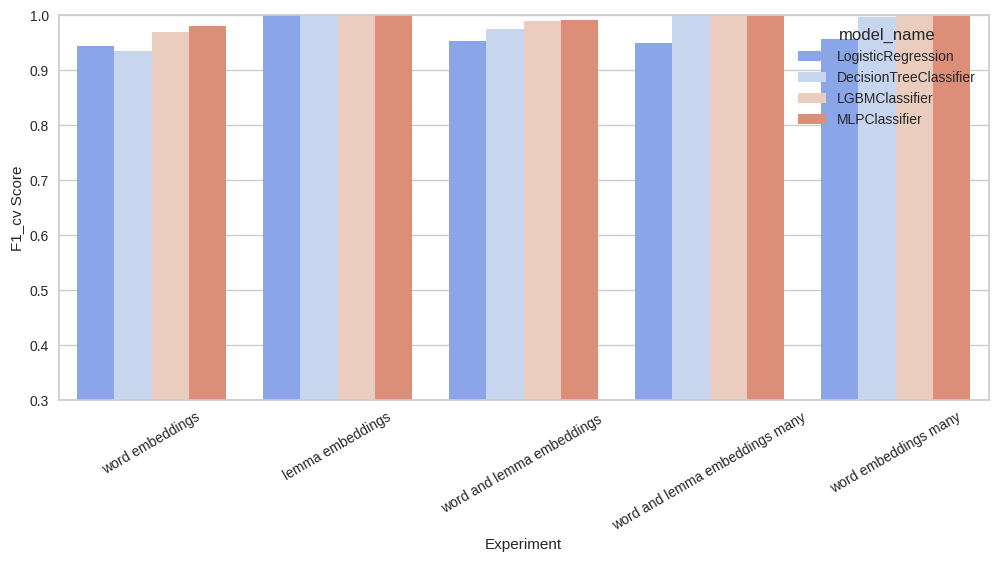

In [197]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

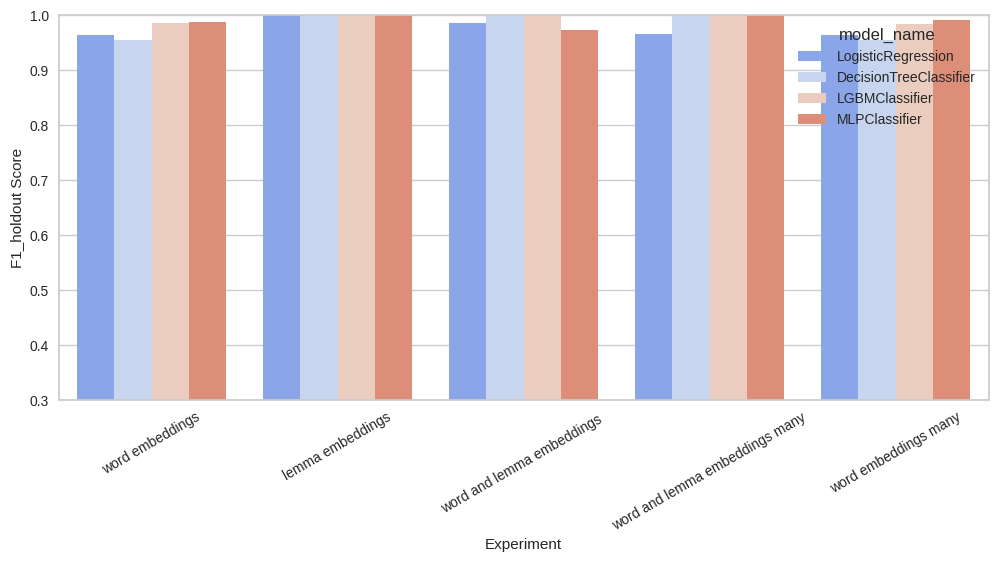

In [198]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

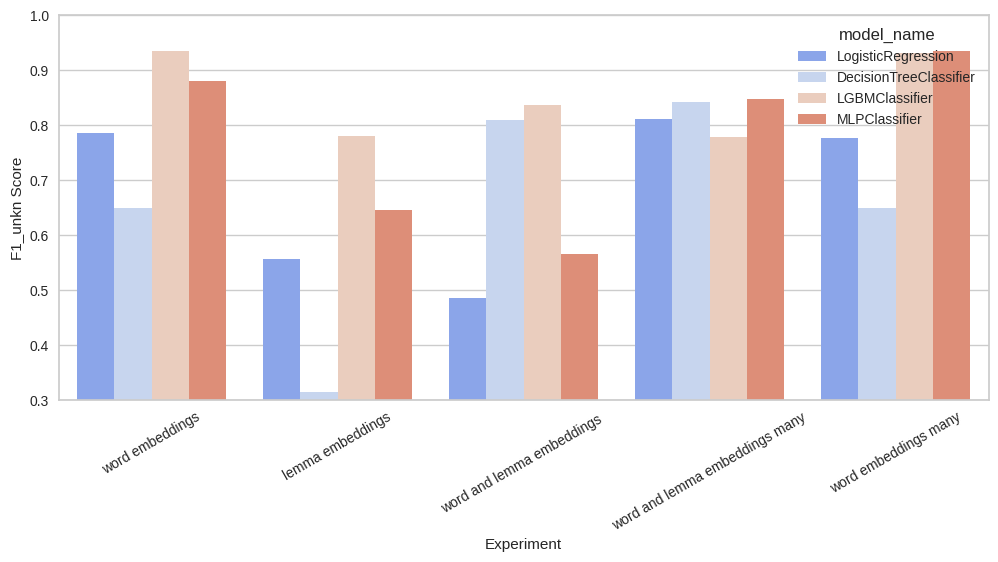

In [199]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [200]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [30, 50, 100],
    "max_depth": [3, 5, 7, -1],
    "num_leaves": [15, 30, 60, 100],
    "subsample": [0.6, 0.8, 1.0],
    "verbose": [-1]
}

In [ ]:
best_params, metric = custom_gridsearch(
    LGBMClassifier,
    param_grid,
    X_train_words_encoded + X_train_words_encoded,
    y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist(),
    X_test_unkn_words_encoded,
    y_test_unkn["aspect"].values.tolist(),
)
best_params, metric

100%|██████████| 432/432 [08:05<00:00,  1.12s/it]


({'learning_rate': 0.1,
  'n_estimators': 100,
  'max_depth': 7,
  'num_leaves': 30,
  'subsample': 0.6,
  'verbose': -1},
 0.9527626446855212)

In [255]:
best_params = {'learning_rate': 0.1,
  'n_estimators': 100,
  'max_depth': 7,
  'num_leaves': 30,
  'subsample': 0.6,
  'verbose': -1}


--- word embeddings: LGBMClassifier ---
 

F1 weighted (Holdout): 0.987 

F1 weighted (Unknown): 0.953 

CV F1: 0.995 

Holdout confusion matrix 

[[ 17   0   2]
 [  0 258   3]
 [  0   2 268]] 

Unknown confusion matrix 

[[290  15]
 [ 11 234]] 

Holdout report: 

              precision    recall  f1-score   support

        both       1.00      0.89      0.94        19
         imp       0.99      0.99      0.99       261
        perf       0.98      0.99      0.99       270

    accuracy                           0.99       550
   macro avg       0.99      0.96      0.97       550
weighted avg       0.99      0.99      0.99       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.96      0.95      0.96       305
        perf       0.94      0.96      0.95       245

    accuracy                           0.95       550
   macro avg       0.95      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550
 



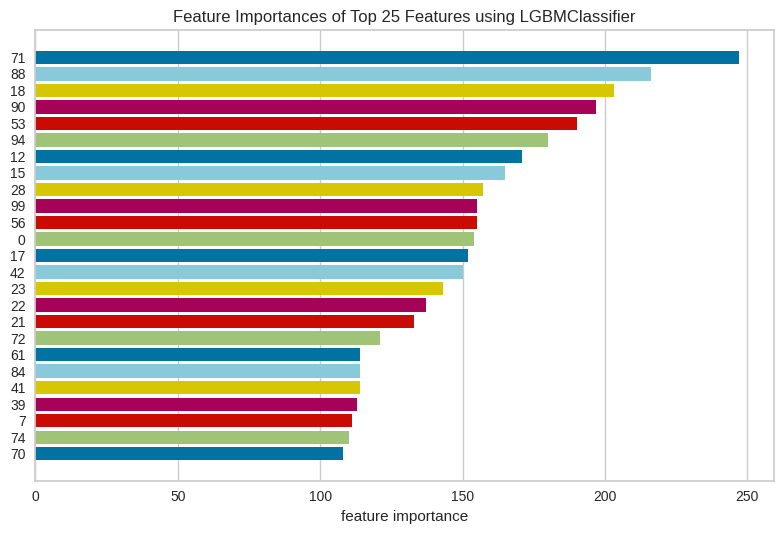

In [256]:
experiment(
    "word embeddings",
    "W2V",
    lambda: LGBMClassifier(**best_params),
    np.array(X_train_words_encoded + X_train_words_encoded),
    X_test_holdout_words_encoded,
    X_test_unkn_words_encoded,
    np.array(y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist()),
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
)

In [213]:
X_train_words_and_nsubj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["nsubj"]))
    for _, row
    in X_train.iterrows()
]

In [ ]:
X_test_holdout_words_and_nsubj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["nsubj"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_nsubj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["nsubj"]))
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_obj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obj"]))
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_obj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obj"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_obj_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obj"]))
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_obl_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obl"]))
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_obl_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obl"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_obl_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["obl"]))
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_advmod_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["advmod"]))
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_advmod_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["advmod"]))
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_advmod_encoded = [
    np.append(encoder.encode(row["word"]), encoder.encode(row["advmod"]))
    for _, row
    in X_test_unkn.iterrows()
]

In [222]:
X_train_words_and_ctx_encoded = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

In [ ]:
experiments = [
    lambda model: experiment(
        "word embeddings nsubj",
        "W2V_ext",
        model,
        X_train_words_and_nsubj_encoded,
        X_test_holdout_words_and_nsubj_encoded,
        X_test_unkn_words_and_nsubj_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings obj",
        "W2V_ext",
        model,
        X_train_words_and_obj_encoded,
        X_test_holdout_words_and_obj_encoded,
        X_test_unkn_words_and_obj_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings obl",
        "W2V_ext",
        model,
        X_train_words_and_obj_encoded,
        X_test_holdout_words_and_obl_encoded,
        X_test_unkn_words_and_obl_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings advmod",
        "W2V_ext",
        model,
        X_train_words_and_advmod_encoded,
        X_test_holdout_words_and_advmod_encoded,
        X_test_unkn_words_and_advmod_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx",
        "W2V_ext",
        model,
        X_train_words_and_ctx_encoded,
        X_test_holdout_words_and_ctx_encoded,
        X_test_unkn_words_and_ctx_encoded,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
]

In [224]:
for e in experiments:
    for model in models:
        e(model)


--- word embeddings ctx: LogisticRegression ---
 

F1 weighted (Holdout): 0.947 

F1 weighted (Unknown): 0.741 

CV F1: 0.930 


--- word embeddings ctx: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.944 

F1 weighted (Unknown): 0.641 

CV F1: 0.914 


--- word embeddings ctx: LGBMClassifier ---
 

F1 weighted (Holdout): 0.989 

F1 weighted (Unknown): 0.945 

CV F1: 0.971 


--- word embeddings ctx: MLPClassifier ---
 

F1 weighted (Holdout): 0.973 

F1 weighted (Unknown): 0.914 

CV F1: 0.969 



In [225]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["W2V_ext"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
92,word embeddings nsubj,W2V_ext,LogisticRegression,False,0.939,0.958,0.775
93,word embeddings nsubj,W2V_ext,DecisionTreeClassifier,False,0.933,0.955,0.793
94,word embeddings nsubj,W2V_ext,LGBMClassifier,False,0.970,0.985,0.923
95,word embeddings nsubj,W2V_ext,MLPClassifier,False,0.969,0.984,0.910
96,word embeddings obj,W2V_ext,LogisticRegression,False,0.942,0.958,0.751


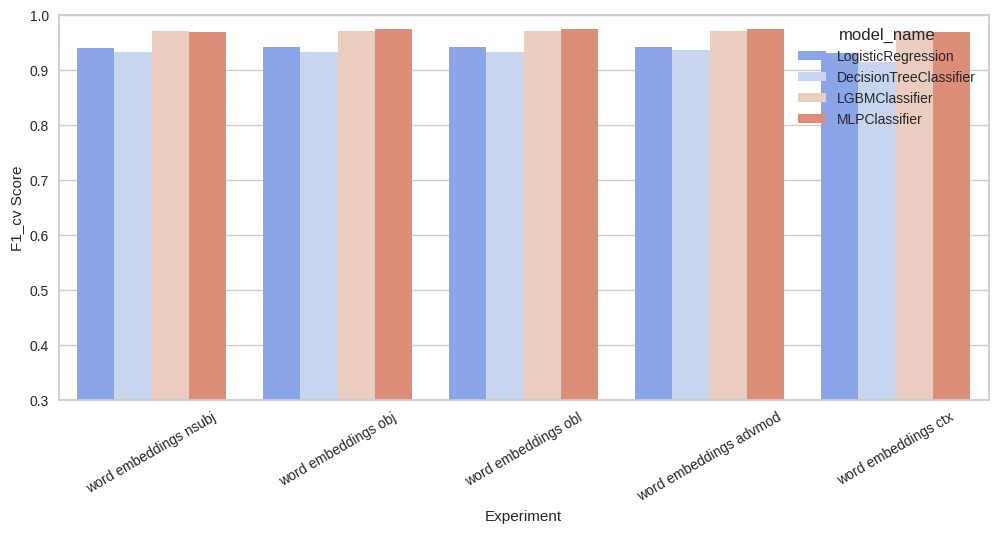

In [226]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

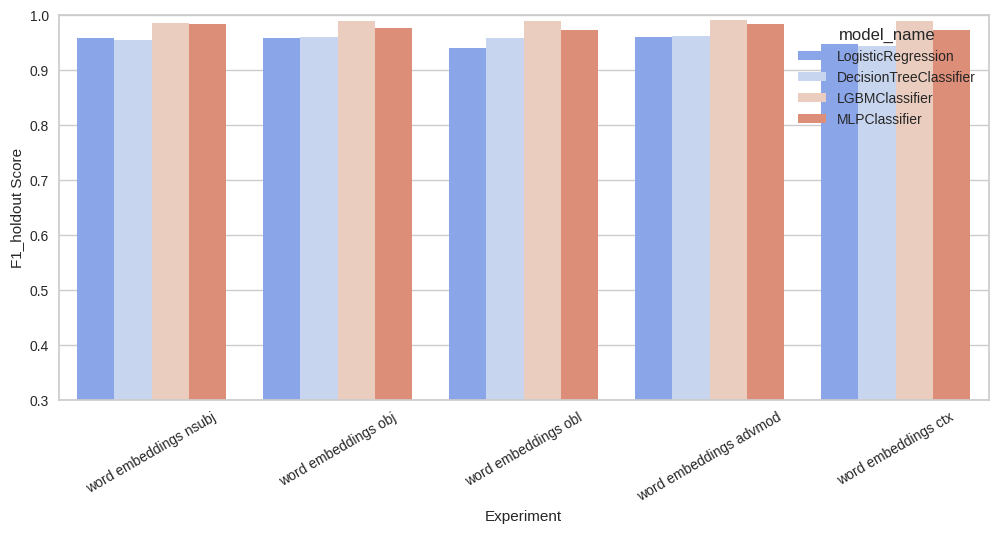

In [227]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

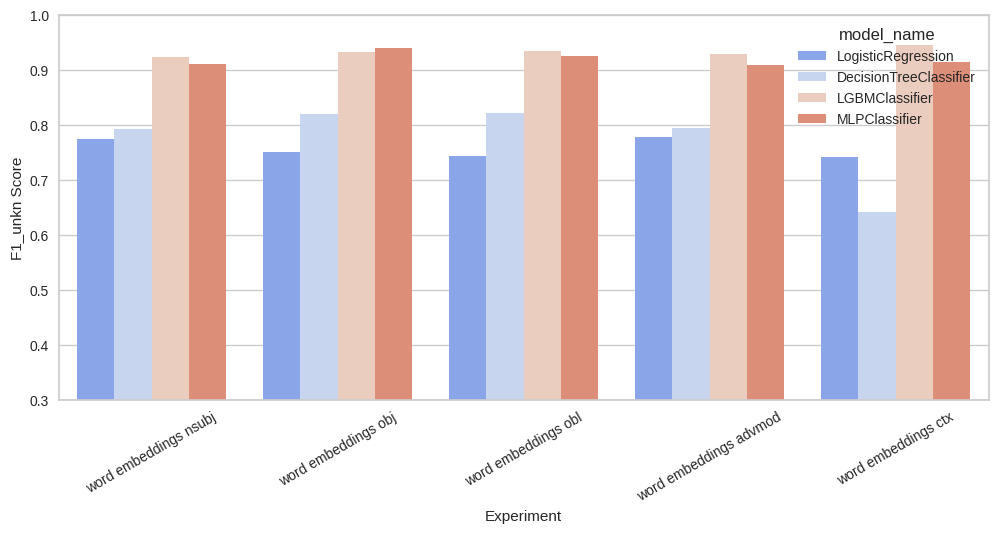

In [228]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [229]:
X_train_words_and_ctx_encoded_3 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_3 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_3 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_2 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_2 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_2 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_2"], row["l_tok_1"], row["r_tok_1"], row["r_tok_2"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_1 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_1"], row["r_tok_1"],])
        )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_1 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_1"], row["r_tok_1"],])
        )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_1 = [
    np.append(
        encoder.encode(row["word"]),
        encoder.encode(
            " ".join([row["l_tok_1"], row["r_tok_1"],])
        )
    )
    for _, row
    in X_test_unkn.iterrows()
]

In [237]:
X_train_words_and_ctx_encoded_3_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
            )
         )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_3_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
            )
         )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_3_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_3"], row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"], row["r_tok_3"],])
            )
         )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_2_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"],])
            )
         )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_2_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"],])
            )
         )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_2_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_2"], row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"], row["r_tok_2"],])
            )
         )
    )
    for _, row
    in X_test_unkn.iterrows()
]

X_train_words_and_ctx_encoded_1_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"],])
            )
         )
    )
    for _, row
    in X_train.iterrows()
]

X_test_holdout_words_and_ctx_encoded_1_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"],])
            )
         )
    )
    for _, row
    in X_test_holdout.iterrows()
]

X_test_unkn_words_and_ctx_encoded_1_split = [
    np.append(
         encoder.encode(" ".join([row["l_tok_1"]])),
         np.append(
             encoder.encode(row["word"]),
            encoder.encode(
                " ".join([row["r_tok_1"],])
            )
         )
    )
    for _, row
    in X_test_unkn.iterrows()
]

In [240]:
experiments = [
    lambda model: experiment(
        "word embeddings ctx 3",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_3,
        X_test_holdout_words_and_ctx_encoded_3,
        X_test_unkn_words_and_ctx_encoded_3,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 2",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_2,
        X_test_holdout_words_and_ctx_encoded_2,
        X_test_unkn_words_and_ctx_encoded_2,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 1",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_1,
        X_test_holdout_words_and_ctx_encoded_1,
        X_test_unkn_words_and_ctx_encoded_1,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 3 split",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_3_split,
        X_test_holdout_words_and_ctx_encoded_3_split,
        X_test_unkn_words_and_ctx_encoded_3_split,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 2 split",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_2_split,
        X_test_holdout_words_and_ctx_encoded_2_split,
        X_test_unkn_words_and_ctx_encoded_2_split,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
    lambda model: experiment(
        "word embeddings ctx 1 split",
        "W2V_ext_ctx",
        model,
        X_train_words_and_ctx_encoded_1_split,
        X_test_holdout_words_and_ctx_encoded_1_split,
        X_test_unkn_words_and_ctx_encoded_1_split,
        y_train["aspect"],
        y_test_holdout["aspect"],
        y_test_unkn["aspect"],
        cv=True,
        log=LOG,
    ),
]

In [241]:
for e in experiments:
    for model in models:
        e(model)


--- word embeddings ctx 3: LogisticRegression ---
 

F1 weighted (Holdout): 0.947 

F1 weighted (Unknown): 0.741 

CV F1: 0.930 


--- word embeddings ctx 3: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.944 

F1 weighted (Unknown): 0.641 

CV F1: 0.914 


--- word embeddings ctx 3: LGBMClassifier ---
 

F1 weighted (Holdout): 0.989 

F1 weighted (Unknown): 0.945 

CV F1: 0.971 


--- word embeddings ctx 3: MLPClassifier ---
 

F1 weighted (Holdout): 0.973 

F1 weighted (Unknown): 0.914 

CV F1: 0.969 


--- word embeddings ctx 2: LogisticRegression ---
 

F1 weighted (Holdout): 0.951 

F1 weighted (Unknown): 0.744 

CV F1: 0.931 


--- word embeddings ctx 2: DecisionTreeClassifier ---
 

F1 weighted (Holdout): 0.940 

F1 weighted (Unknown): 0.643 

CV F1: 0.918 


--- word embeddings ctx 2: LGBMClassifier ---
 

F1 weighted (Holdout): 0.985 

F1 weighted (Unknown): 0.925 

CV F1: 0.970 


--- word embeddings ctx 2: MLPClassifier ---
 

F1 weighted (Holdout): 0.978 

F1 weigh

In [242]:
scores_df = pd.read_csv(
    LOG.fname,
    sep=LOG.sep
)
scores_df = scores_df[
    scores_df["experiment_group"].isin(["W2V_ext_ctx"])
]
scores_df.head()

,experiment_name,experiment_group,model_name,PCA,F1_cv,F1_holdout,F1_unkn
112,word embeddings ctx 3,W2V_ext_ctx,LogisticRegression,False,0.930,0.947,0.741
113,word embeddings ctx 3,W2V_ext_ctx,DecisionTreeClassifier,False,0.914,0.944,0.641
114,word embeddings ctx 3,W2V_ext_ctx,LGBMClassifier,False,0.971,0.989,0.945
115,word embeddings ctx 3,W2V_ext_ctx,MLPClassifier,False,0.969,0.973,0.914
116,word embeddings ctx 2,W2V_ext_ctx,LogisticRegression,False,0.931,0.951,0.744


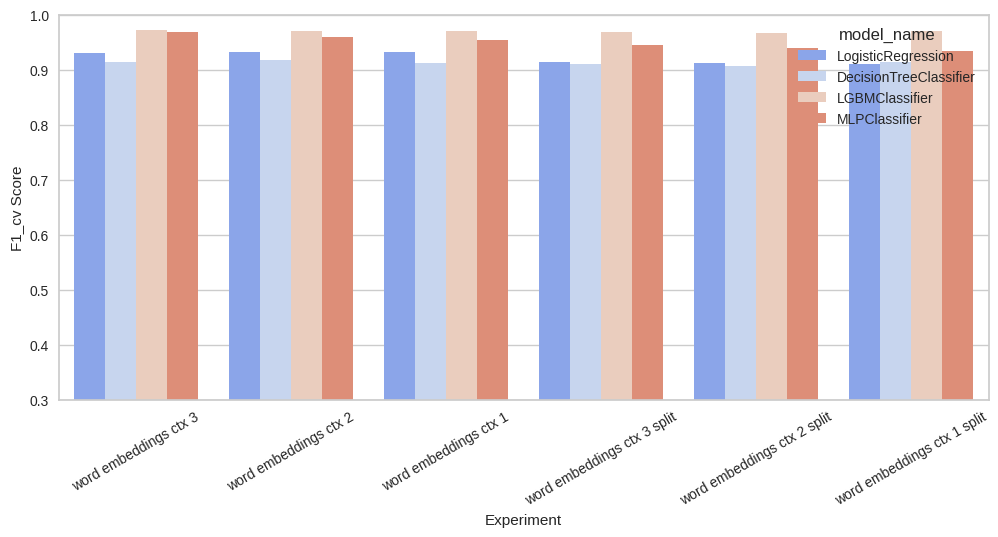

In [243]:
plot_metrics(scores_df, "F1_cv", min_=0.30)

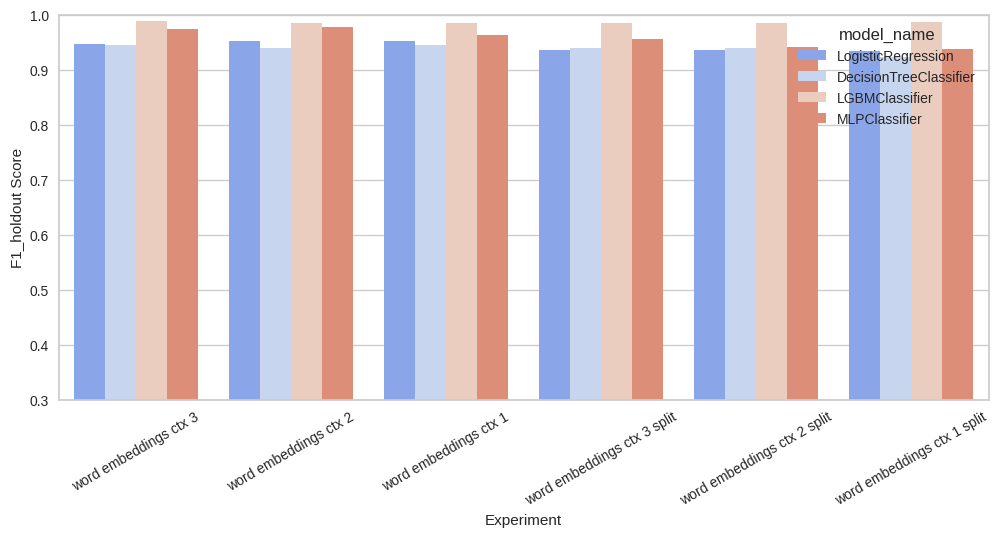

In [244]:
plot_metrics(scores_df, "F1_holdout", min_=0.30)

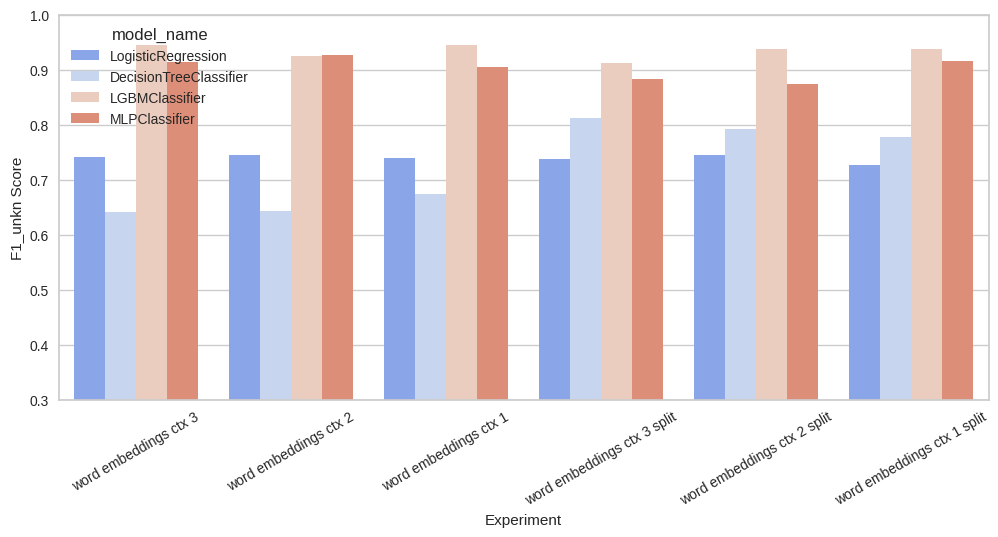

In [245]:
plot_metrics(scores_df, "F1_unkn", min_=0.30)

In [246]:
scores_df.loc[scores_df["F1_unkn"].idxmax()]

experiment_name     word embeddings ctx 3
experiment_group              W2V_ext_ctx
model_name                 LGBMClassifier
PCA                                 False
F1_cv                               0.971
F1_holdout                          0.989
F1_unkn                             0.945
Name: 114, dtype: object

In [248]:
param_grid = {
    "learning_rate": [0.05, 0.1],
    "n_estimators": [30, 50, 100],
    "max_depth": [3, 5, 7, -1],
    "num_leaves": [15, 30, 60, 100],
    "subsample": [0.6, 0.8, 1.0],
    "verbose": [-1]
}

In [ ]:
# best_params, metric = custom_gridsearch(
#     LGBMClassifier,
#     param_grid,
#     X_train_words_and_ctx_encoded_3,
#     y_train["aspect"].values.tolist(),
#     X_test_unkn_words_and_ctx_encoded_3,
#     y_test_unkn["aspect"].values.tolist(),
# )
# best_params, metric

100%|██████████| 288/288 [08:00<00:00,  1.67s/it]


({'learning_rate': 0.05,
  'n_estimators': 100,
  'max_depth': 7,
  'num_leaves': 30,
  'subsample': 0.6,
  'verbose': -1},
 0.9527626446855212)

In [253]:
best_params = {'learning_rate': 0.05,
  'n_estimators': 100,
  'max_depth': 7,
  'num_leaves': 30,
  'subsample': 0.6,
  'verbose': -1}


--- word embeddings ctx 3: LGBMClassifier ---
 

F1 weighted (Holdout): 0.985 

F1 weighted (Unknown): 0.953 

CV F1: 0.967 

Holdout confusion matrix 

[[ 17   0   2]
 [  0 257   4]
 [  0   2 268]] 

Unknown confusion matrix 

[[290  15]
 [ 11 234]] 

Holdout report: 

              precision    recall  f1-score   support

        both       1.00      0.89      0.94        19
         imp       0.99      0.98      0.99       261
        perf       0.98      0.99      0.99       270

    accuracy                           0.99       550
   macro avg       0.99      0.96      0.97       550
weighted avg       0.99      0.99      0.99       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.96      0.95      0.96       305
        perf       0.94      0.96      0.95       245

    accuracy                           0.95       550
   macro avg       0.95      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550
 

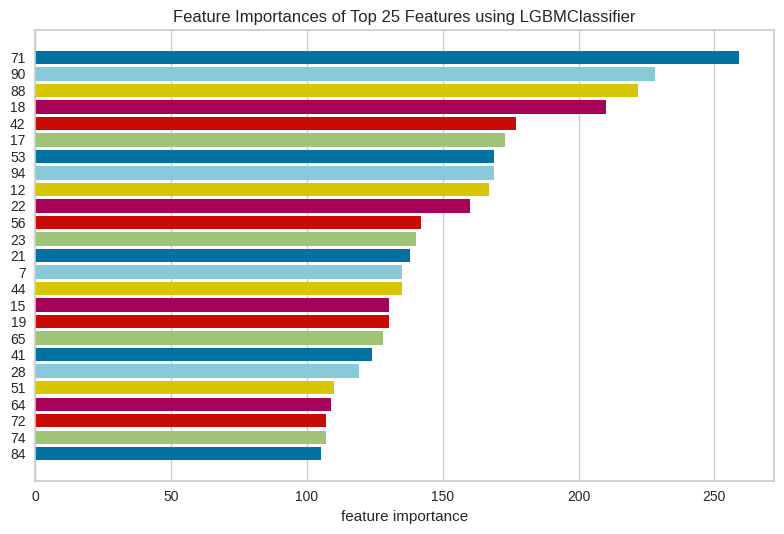

(None,)

In [254]:
experiment(
    "word embeddings ctx 3",
    "W2V_ext_ctx",
    lambda: LGBMClassifier(**best_params),
    np.array(X_train_words_and_ctx_encoded_3),
    np.array(X_test_holdout_words_and_ctx_encoded_3),
    np.array(X_test_unkn_words_and_ctx_encoded_3),
    y_train["aspect"],
    y_test_holdout["aspect"],
    y_test_unkn["aspect"],
    cv=True,
    log=None,
    fi=True,
    report=True,
    confusion=True
),

### Собираем финальный инструмент

In [278]:
categorical_lgbm = LGBMClassifier(
    **{
        'learning_rate': 0.05,
        'n_estimators': 50,
        'max_depth': -1,
        'num_leaves': 30,
        'subsample': 0.6,
        'verbose': -1
    }
)

categorical_lgbm.fit(
    one_hot_encode(
        X_train_graphemes_and_grammar_categories,
        X_test_holdout_graphemes_and_grammar_categories,
        X_test_unkn_graphemes_and_grammar_categories,
    )[0],
    y_train["aspect"]
)

LGBMClassifier(learning_rate=0.05, n_estimators=50, num_leaves=30,
               subsample=0.6, verbose=-1)

In [279]:
w2v_lgbm = LGBMClassifier(
    **{
        'learning_rate': 0.1,
        'n_estimators': 100,
        'max_depth': 7,
        'num_leaves': 30,
        'subsample': 0.6,
        'verbose': -1
    }
)

w2v_lgbm.fit(
    np.array(X_train_words_encoded + X_train_words_encoded),
    np.array(y_train["aspect"].values.tolist() + y_train["aspect"].values.tolist())
)

LGBMClassifier(max_depth=7, num_leaves=30, subsample=0.6, verbose=-1)

In [331]:
categorical_columns = X_train_graphemes_and_grammar_categories.columns.tolist()
categorical_columns

['l_gr_1',
 'l_gr_2',
 'r_gr_1',
 'r_gr_2',
 'Gender',
 'Mood',
 'Number',
 'Person',
 'Tense',
 'VerbForm',
 'Voice']

In [332]:
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
onehot_encoder.fit(X_train[categorical_columns])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [370]:
class Predictor:
    """
        Пытается сделать предсказание по Word2Vec
        Если вектора нет, берет грамматику и графемы
    """

    def __init__(
        self,
        string_encoder,
        categorical_encoder,
        categorical_classifier,
        embedding_classifier
    ):
        self.string_encoder = string_encoder
        self.categorical_encoder = categorical_encoder
        self.categorical_classifier = categorical_classifier
        self.embedding_classifier = embedding_classifier

    def predict_(self, x):
        word, *categorical = x
        embedding = np.array(self.string_encoder.encode(word))

        if np.all(embedding == 0):
            oh_vector = self.categorical_encoder.transform(np.array(categorical).reshape(1, -1))
            pred = self.categorical_classifier.predict(oh_vector)
        else:
            pred = self.embedding_classifier.predict(embedding.reshape(1, -1))

        return pred[0]

    def predict(self, X):
        """
            X -- слово, категориальные фичи
        """

        result = [self.predict_(x) for x in X]
        return result

In [371]:
predictor = Predictor(encoder, onehot_encoder, categorical_lgbm, w2v_lgbm)

In [372]:
predictor.predict([["raditi", 1 ,2 ,3]])

['imp']

In [373]:
predictor.predict([["radio", 1 ,2 ,3]])

['imp']

In [374]:
predictor.predict([["radila", 1 ,2 ,3]])

['imp']

In [375]:
predictor.predict([["uraditi", 1 ,2 ,3]])

['perf']

In [376]:
predictor.predict([["uradio", 1 ,2 ,3]])

['perf']

In [377]:
predictor.predict([["uradila", 1 ,2 ,3]])

['perf']

In [390]:
categorical_columns

['l_gr_1',
 'l_gr_2',
 'r_gr_1',
 'r_gr_2',
 'Gender',
 'Mood',
 'Number',
 'Person',
 'Tense',
 'VerbForm',
 'Voice']

In [393]:
predictor.predict([["dobila", "d", "o", "a", "l", "Fem", "[PAD]", "Sing", "3", "Past", "Part", "Act"]])

['perf']

In [384]:
X_test_holdout_final = X_test_holdout[["word"] + categorical_columns]
X_test_holdout_final.head()

,word,l_gr_1,l_gr_2,r_gr_1,r_gr_2,Gender,Mood,Number,Person,Tense,VerbForm,Voice
3437,razgovara,r,a,a,r,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
1781,obećao,o,b,o,a,Masc,[PAD],Sing,[PAD],Past,Part,Act
4583,vidi,v,i,i,d,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
519,ima,i,m,a,m,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
571,imaju,i,m,u,j,[PAD],Ind,Plur,3,Pres,Fin,[PAD]


In [385]:
X_test_unkn_final = X_test_unkn[["word"] + categorical_columns]
X_test_unkn_final.head()

,word,l_gr_1,l_gr_2,r_gr_1,r_gr_2,Gender,Mood,Number,Person,Tense,VerbForm,Voice
36,boravi,b,o,i,v,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
37,boravi,b,o,i,v,[PAD],Ind,Sing,3,Pres,Fin,[PAD]
38,boravila,b,o,a,l,Fem,[PAD],Sing,[PAD],Past,Part,Act
39,boravila,b,o,a,l,Fem,[PAD],Sing,[PAD],Past,Part,Act
40,boravio,b,o,o,i,Masc,[PAD],Sing,[PAD],Past,Part,Act


In [389]:
preds_holdout = predictor.predict(X_test_holdout_final.to_numpy())
preds_unkn    = predictor.predict(X_test_unkn_final.to_numpy())

to_print = [f"\n--- FINAL ---\n"]

f1_wtd_holdout = f1_score(y_test_holdout["aspect"], preds_holdout, average="weighted")
f1_wtd_unkn    = f1_score(y_test_unkn["aspect"], preds_unkn, average="weighted")
to_print.append(f"F1 weighted (Holdout): {f1_wtd_holdout:.3f}")
to_print.append(f"F1 weighted (Unknown): {f1_wtd_unkn:.3f}")

confusions_holdount = confusion_matrix(y_test_holdout["aspect"], preds_holdout)
confusions_unkn     = confusion_matrix(y_test_unkn["aspect"], preds_unkn)
to_print.append("Holdout confusion matrix")
to_print.append(confusions_holdount)
to_print.append("Unknown confusion matrix")
to_print.append(confusions_unkn)

holdout_report = classification_report(
    y_test_holdout["aspect"],
    preds_holdout,
    zero_division=1.0
)
unkn_report = classification_report(
    y_test_unkn["aspect"],
    preds_unkn,
    zero_division=1.0
)
to_print.append("Holdout report:")
to_print.append(holdout_report)
to_print.append("Unknown report:")
to_print.append(unkn_report)

list(
    map(lambda string: print(string, "\n"), to_print)
)


--- FINAL ---
 

F1 weighted (Holdout): 0.987 

F1 weighted (Unknown): 0.953 

Holdout confusion matrix 

[[ 17   0   2]
 [  0 258   3]
 [  0   2 268]] 

Unknown confusion matrix 

[[290  15]
 [ 11 234]] 

Holdout report: 

              precision    recall  f1-score   support

        both       1.00      0.89      0.94        19
         imp       0.99      0.99      0.99       261
        perf       0.98      0.99      0.99       270

    accuracy                           0.99       550
   macro avg       0.99      0.96      0.97       550
weighted avg       0.99      0.99      0.99       550
 

Unknown report: 

              precision    recall  f1-score   support

         imp       0.96      0.95      0.96       305
        perf       0.94      0.96      0.95       245

    accuracy                           0.95       550
   macro avg       0.95      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550
 



[None, None, None, None, None, None, None, None, None, None, None]